In [1]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import random
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
#import cufflinks as cf
#cf.go_offline()
from wordcloud import WordCloud , ImageColorGenerator
import nltk as nltk
import nltk
nltk.download('wordnet')
import string
from nltk.tokenize import word_tokenize  # For text tokenization
from nltk.corpus import stopwords  # For stopword removal
from sklearn.feature_extraction.text import TfidfVectorizer  # For cosine similarity
from textblob import TextBlob  # For sentiment analysis
from nltk.corpus import stopwords
from textblob import TextBlob
import emoji
#from emoji import UNICODE_EMOJI
import contractions
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer  # Stemming and Lemmatization
from collections import Counter  # For n-gram frequency
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Reading in Appliances sample data
appliances_df = pd.read_csv('Applicances_Superset_data.csv')

/tmp/ipykernel_10588/3289130923.py:2: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
# Creating copy for backup
appliances_df_working = appliances_df.copy()

In [5]:
# Data snapshot
appliances_df_working.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


In [6]:
appliances_df_working.dtypes

overall            int64
vote              object
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
image             object
dtype: object

In [7]:
# Checking and removing duplicates

# Original dataset count
print("Before deduplication shape:")
print(appliances_df_working.shape)

# Performing deduplication
appliances_df_working_dedup = appliances_df_working.drop_duplicates()

# Print the DataFrame after deduplication
print("\nAfter deduplication shape:")
print(appliances_df_working_dedup.shape)

Before deduplication shape:
(602777, 12)

After deduplication shape:
(591371, 12)


In [8]:
# Calculating percentage of duplicates removed
original_count = appliances_df_working.shape[0]
deduplicated_count = appliances_df_working_dedup.shape[0]
percentage_removed = ((original_count - deduplicated_count) / original_count) * 100

print("\nPercentage of duplicates removed:", percentage_removed, "%")


Percentage of duplicates removed: 1.8922420729390803 %


#  After deduplication, dataset shrinkage is negligible.
#### After deduplication from overall data, less than 2% of overall data was duplicate which is fine considering the amount of data for applicances category

In [10]:
# Function to count missing values (including NA, NaNs, and 0)
def count_missing(df):
    missing_counts = df.isna().sum()  # Count missing values (NaN)
    missing_counts = missing_counts.add(df.eq(0).sum(), axis=0)  # Count zeros
    return missing_counts

# Printing the counts of missing values
missing_value_counts = count_missing(appliances_df_working_dedup.copy())
print(missing_value_counts)

overall                0
vote              529749
verified           37781
reviewTime             0
reviewerID             0
asin                   0
style             455622
reviewerName          80
reviewText           351
summary              138
unixReviewTime         0
image             583097
dtype: int64


### Data overview and treatment required

1) overall = star rating, keep as is
2) verified = is this verified purchase or not? convert blank to false and to be used for getting helpfulness dependent variable
3) reviewTime = this is in mm dd, yyyy format, need to convert to standard format and then subtract from end of 2018 to get review age
4) reviewerID = ID of the reviewer, keep as is
5) asin = Amazon Standard Identification Number, standard product ID number, keep as is
6) style = describes the SKU or variant, attempt to standardize
7) reviewName = name of the reviewer, keep as is
8) reviewText = actual review text; meta data to be extracted from raw data, text cleaning/mining to be performed and then converted to tfidf matrix
9) summary = review title, meta data to be extracted, similarity to reviewText to be calculated
10) vote = number of votes for helpfulness, convert blank to 0 and to be used for getting helpfulness dependent variable
11) image = URL of image if available, to be converted to flag of whether image is available or not

In [11]:
# Data treatment
# reviewTime date standardization

# format string from the original date format
format_string = "%m %d, %Y"  # mm dd, yyyy

# Standardizing date format
appliances_df_working_dedup["reviewTime_cleaned"] = pd.to_datetime(appliances_df_working_dedup["reviewTime"], format=format_string)

# Checking to see if it worked
appliances_df_working_dedup.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewTime_cleaned
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN,2013-11-27
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN,2013-11-01
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN,2013-10-10
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN,2013-10-09
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN,2013-09-07


In [12]:
appliances_df_working_dedup.shape

(591371, 13)

#### After filtering the data for 2010-2018, we have excluded 3560 records or 0.60% of data which is negligible

In [13]:
# Extracting year, month, day from the review datetime
appliances_df_working_dedup["review_year"] = pd.to_datetime(appliances_df_working_dedup["reviewTime_cleaned"]).dt.year
appliances_df_working_dedup["review_month"] = pd.to_datetime(appliances_df_working_dedup["reviewTime_cleaned"]).dt.month
appliances_df_working_dedup["review_day"] = pd.to_datetime(appliances_df_working_dedup["reviewTime_cleaned"]).dt.day

# Filtering out data before 2010
appliances_df_working_dedup_filter = appliances_df_working_dedup[(appliances_df_working_dedup['review_year'] >= 2010) &
                                           (appliances_df_working_dedup['review_year'] <= 2018)]

In [14]:
# Calculating percentage of filtered records after filtering data for 2010-2018
original_count = 591371
filter_count = appliances_df_working_dedup_filter.shape[0]
percentage_removed = ((original_count-filter_count)  / original_count)
print(percentage_removed)

0.00601990966753527


In [15]:
# Data treatment
# Verified imputation
# There are 37781 missing values for which we will impute with False
# If there is missing data then it is false

# Imputing missing values with False in the verified column
appliances_df_working_dedup_filter['verified_clean'] = appliances_df_working_dedup_filter['verified'].fillna(False)

# Checking the imputation
print(appliances_df_working_dedup_filter['verified_clean'].isnull().sum())  # Should be 0 after imputation

0


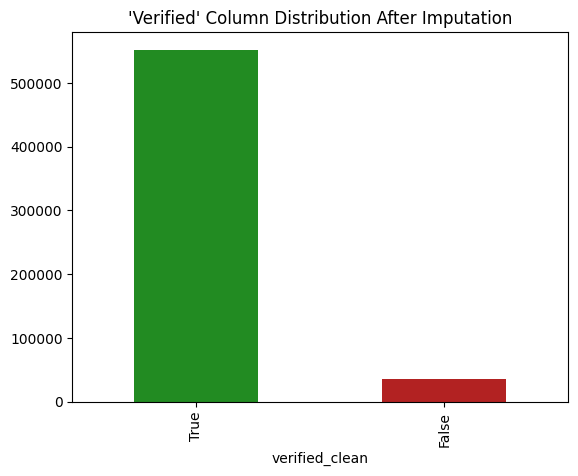

In [16]:
# Plotting the distribution of the 'verified_clean' column after imputation

# Counting the occurrences of each unique value in the 'verified_clean' column
value_counts = appliances_df_working_dedup_filter['verified_clean'].value_counts()

# Defining colors for the bars
colors = ['forestgreen', 'firebrick']

# Creating a bar plot to visualize the distribution
value_counts.plot(kind='bar', color=colors)

# Adding title to the plot
plt.title("'Verified' Column Distribution After Imputation")

# Displaying the plot
plt.show()

In [17]:
# Data treatment
# Vote imputation
# There are 529749 missing values for which we will impute with 0
# 529K. If the votes are missing, then they are zero and hence we are imputing with zero

# Imputing missing values with 0
appliances_df_working_dedup_filter["vote_clean"] = appliances_df_working_dedup_filter["vote"].fillna(0)

# Checking the imputation
print(appliances_df_working_dedup_filter['vote_clean'].isnull().sum())  # Should be 0 after imputation

0


In [18]:
# Data treatment
# reviewName imputation
# There are 80 missing values which will be imputed with "Unknown"
# If the reviewer name is missing, we don't know who the user is and hence, we are imputing the missing values with "Unknown".
appliances_df_working_dedup["reviewerName_clean"] = appliances_df_working_dedup["reviewerName"].fillna("Unknown")

# Checking the imputation
print(appliances_df_working_dedup['reviewerName_clean'].isnull().sum())  # Should be 0 after imputation.

0


In [19]:
# Data treatment
# reviewText imputation
# There are 351 missing values in reviewText and hence, these records will be excluded. We are excluding because it is neglible

appliances_df_working_dedup = appliances_df_working_dedup.dropna(subset=["reviewText"])
# Checking the imputation
print(appliances_df_working_dedup['reviewText'].isnull().sum())  # Should be 0 after imputation.

0


In [20]:
# Data treatment
# summary imputation
# There are 138 missing values in summary which will be excluded because it is neglible
appliances_df_working_dedup = appliances_df_working_dedup.dropna(subset=["summary"])
# Checking the imputation
print(appliances_df_working_dedup['summary'].isnull().sum())  # Should be 0 after imputation.

0


In [21]:
# Data treatment
# Image URL availability

# Defining a regular expression for URL validation
# Observed from the data that non-null values have https pattern
url_regex = r"https?://\S+"

# Creating a new column with flag based on URL presence
appliances_df_working_dedup_filter['image_available'] = appliances_df_working_dedup_filter['image'].apply(lambda x:
                                                                                            bool(re.match(url_regex, str(x))))

# Check
appliances_df_working_dedup_filter.tail()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewTime_cleaned,review_year,review_month,review_day,verified_clean,vote_clean,image_available
602772,5,NaN,True,"08 10, 2017",A24A9P4F2SLTK5,B01HJH2PY0,NaN,Tana,perfect replacement for our broken one.,Five Stars,1502323200,NaN,2017-08-10,2017,8,10,True,0,False
602773,2,NaN,True,"08 1, 2018",A2JCB4KHBWEELW,B01HJHHEA0,NaN,CMA,"Quick delivery, did not fit my stove.",Two Stars,1533081600,NaN,2018-08-01,2018,8,1,True,0,False
602774,5,NaN,True,"04 13, 2018",A1LDYYVTLPP2Z5,B01HJHHEA0,NaN,Himmy,Perfect match for my oven!,Five Stars,1523577600,NaN,2018-04-13,2018,4,13,True,0,False
602775,1,NaN,True,"03 23, 2018",AP1M5O06IOYZ7,B01HJH92JQ,NaN,Alberto,Doesn't work with Bosch SHX33A06UC/14 dishwash...,Doesn't work with Bosch SHX33A06UC/14 dishwash...,1521763200,NaN,2018-03-23,2018,3,23,True,0,False
602776,3,NaN,True,"01 8, 2018",A1BU98NV4Y0P9K,B01HJH92JQ,NaN,RobMckenner,The switch works with my dishwasher after I mo...,The switch works with my dishwasher after I mo...,1515369600,NaN,2018-01-08,2018,1,8,True,0,False


## Creating the dependent variable - helpfulness

In [22]:
appliances_df_working_dedup_filter.dtypes
# vote_clean is a string, needs to be converted to numeric

appliances_df_working_dedup_filter["vote_clean"] = pd.to_numeric(appliances_df_working_dedup_filter["vote_clean"],
                                                                 errors='coerce')

In [23]:
#appliances_df_working_dedup.dtypes
appliances_df_working_dedup_filter.describe()

,overall,unixReviewTime,reviewTime_cleaned,review_year,review_month,review_day,vote_clean
count,587811.000000,5.878110e+05,587811,587811.000000,587811.000000,587811.000000,587807.000000
mean,4.278373,1.457086e+09,2016-03-04 09:58:53.231599872,2015.696283,6.254769,15.698728,0.822309
min,1.000000,1.262304e+09,2010-01-01 00:00:00,2010.000000,1.000000,1.000000,0.000000
25%,4.000000,1.424650e+09,2015-02-23 00:00:00,2015.000000,3.000000,8.000000,0.000000
50%,5.000000,1.464912e+09,2016-06-03 00:00:00,2016.000000,6.000000,16.000000,0.000000
75%,5.000000,1.496621e+09,2017-06-05 00:00:00,2017.000000,9.000000,23.000000,0.000000
max,5.000000,1.538611e+09,2018-10-04 00:00:00,2018.000000,12.000000,31.000000,970.000000
std,1.299453,5.103983e+07,NaN,1.654979,3.478250,8.826655,7.686854


In [24]:
appliances_df_working_dedup_filter.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewTime_cleaned,review_year,review_month,review_day,verified_clean,vote_clean,image_available
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN,2013-11-27,2013,11,27,False,2.0,False
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN,2013-11-01,2013,11,1,False,0.0,False
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN,2013-10-10,2013,10,10,False,0.0,False
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN,2013-10-09,2013,10,9,False,0.0,False
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN,2013-09-07,2013,9,7,False,10.0,False


In [25]:
appliances_df_working_dedup_filter['vote_clean'].dtype

dtype('float64')

In [26]:
# Checking for non-numeric values after conversion
non_numeric_count = appliances_df_working_dedup_filter["vote_clean"].isna().sum()
if non_numeric_count > 0:
    print(f"Warning: {non_numeric_count} non-numeric values in vote_clean after conversion")


In [27]:
appliances_df_working_dedup_filter["vote_clean"].unique()

array([  2.,   0.,  10.,   3.,   5.,   4.,  21.,   7.,   8.,  11.,   9.,
        35.,  17.,   6.,  83.,  12.,  18.,  39.,  19.,  23.,  14.,  40.,
        49.,  15., 116.,  13.,  22.,  16.,  67.,  33.,  44.,  20.,  26.,
        42., 295.,  25., 173., 259.,  93.,  41.,  30.,  63.,  24.,  60.,
        71.,  31.,  28.,  58.,  91.,  34., 172., 105.,  32., 180.,  47.,
       111., 152., 163.,  85.,  27., 199., 244., 491., 154., 228., 137.,
        51.,  43., 193.,  36.,  37.,  50., 136.,  65.,  70.,  38.,  29.,
        57.,  46.,  52., 204., 167.,  95.,  84.,  45.,  87., 104., 115.,
       161., 279.,  53.,  90.,  55.,  78., 170., 548.,  77., 326., 970.,
        81., 523.,  68.,  73.,  76.,  99.,  74.,  64., 557.,  62., 203.,
       174., 213., 134., 127.,  69.,  48., 125., 309., 165., 219.,  nan,
       122., 168., 101., 100., 222., 184., 182., 103.,  89., 139., 285.,
       129.,  80., 117.,  59., 646., 346.,  61.,  72., 311.,  66., 372.,
       802., 112., 181., 108., 432., 542., 442., 15

In [28]:
print(appliances_df_working_dedup_filter.columns)

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'image_available'],
      dtype='object')


In [29]:
# For some reason, nan isn't going away, dropping 4 rows
# There are only 4 values which are nan and it is convenient to drop these values.
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["vote_clean"])

In [30]:
appliances_df_working_dedup_filter.shape

(587807, 19)

In [31]:
appliances_df_working_dedup_filter["vote_clean"].unique()

array([  2.,   0.,  10.,   3.,   5.,   4.,  21.,   7.,   8.,  11.,   9.,
        35.,  17.,   6.,  83.,  12.,  18.,  39.,  19.,  23.,  14.,  40.,
        49.,  15., 116.,  13.,  22.,  16.,  67.,  33.,  44.,  20.,  26.,
        42., 295.,  25., 173., 259.,  93.,  41.,  30.,  63.,  24.,  60.,
        71.,  31.,  28.,  58.,  91.,  34., 172., 105.,  32., 180.,  47.,
       111., 152., 163.,  85.,  27., 199., 244., 491., 154., 228., 137.,
        51.,  43., 193.,  36.,  37.,  50., 136.,  65.,  70.,  38.,  29.,
        57.,  46.,  52., 204., 167.,  95.,  84.,  45.,  87., 104., 115.,
       161., 279.,  53.,  90.,  55.,  78., 170., 548.,  77., 326., 970.,
        81., 523.,  68.,  73.,  76.,  99.,  74.,  64., 557.,  62., 203.,
       174., 213., 134., 127.,  69.,  48., 125., 309., 165., 219., 122.,
       168., 101., 100., 222., 184., 182., 103.,  89., 139., 285., 129.,
        80., 117.,  59., 646., 346.,  61.,  72., 311.,  66., 372., 802.,
       112., 181., 108., 432., 542., 442., 156., 89

In [32]:
# Checking for NaN values in summary
summary_nan_count = appliances_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary after conversion")


There were 138 NaN values in summary which is negligible hence they are dropped

In [33]:
# NaN will be dropped in the summary
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["summary"])

In [34]:
# Checking for NaN values in # reviewText
reviewText_nan_count = appliances_df_working_dedup_filter["reviewText"].isna().sum()
if reviewText_nan_count > 0:
    print(f"Warning: {reviewText_nan_count} nan values in review Text")


There were 333 NaN values in review Text which is negligible hence they are dropped

In [35]:
# NaN will be dropped in the reviewText
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["reviewText"])

In [36]:
# Checking for non-numeric values after conversion
summary_nan_count = appliances_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary")

In [37]:
# For some reason, nan isn't going away, dropping 2 rows
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["vote_clean"])

In [38]:
appliances_df_working_dedup_filter.shape

(587336, 19)

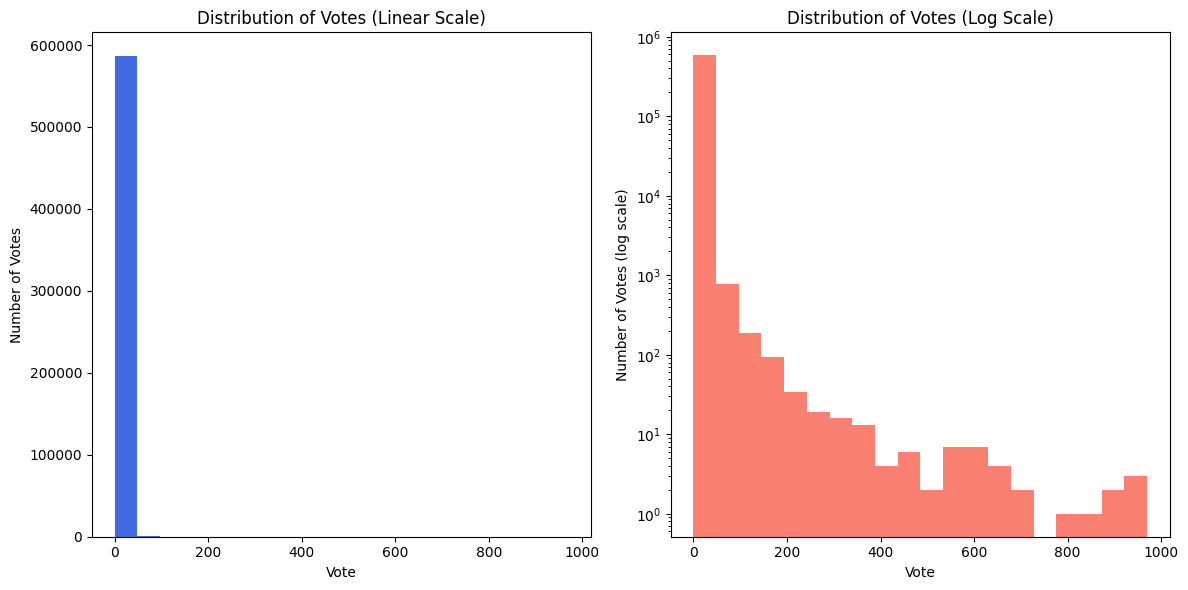

In [39]:
# Creating a figure and axis objects for subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Distribution of votes (linear scale)
axs[0].hist(appliances_df_working_dedup_filter['vote_clean'], bins=20, color='royalblue')
axs[0].set_xlabel("Vote")
axs[0].set_ylabel("Number of Votes")
axs[0].set_title("Distribution of Votes (Linear Scale)")

# Subplot 2: Distribution of votes (log scale)
axs[1].hist(appliances_df_working_dedup_filter['vote_clean'], bins=20, color='salmon', log=True)
axs[1].set_xlabel("Vote")
axs[1].set_ylabel("Number of Votes (log scale)")
axs[1].set_title("Distribution of Votes (Log Scale)")

# Adjust layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
# Cross tab of vote counts
# Cross tabulation of vote counts
print(appliances_df_working_dedup_filter['vote_clean'].value_counts().sort_index(ascending=True))

vote_clean
0.0      528014
2.0       20106
3.0       10338
4.0        6090
5.0        4029
          ...  
894.0         1
915.0         1
927.0         1
930.0         1
970.0         1
Name: count, Length: 279, dtype: int64


In [40]:
# Creating our dependent variable 'helpfulness_binary' with the following conditions
# 1 if Votes > 0 and verified is True
# 0 otherwise
appliances_df_working_dedup_filter['helpfulness_binary'] = appliances_df_working_dedup_filter[['vote_clean', 'verified_clean']].apply(lambda x:
                                                        1 if x['vote_clean'] > 0
                                                        and x['verified_clean'] else 0,
                                                        axis=1)

# Checking counts
print(appliances_df_working_dedup_filter['helpfulness_binary'].value_counts().sort_index(ascending=True))


helpfulness_binary
0    540331
1     47005
Name: count, dtype: int64


In [42]:
# Calculating the total number of entries
total_entries = len(appliances_df_working_dedup_filter)

# Calculating the count 'helpfulness_binary'
helpfulness_counts = appliances_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculating the percentage 
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 8.003085116526146
Percentage of Not helpfulness 91.99691488347386


#### Helpfulness is 8% and 92% is not helpful

### Stratified sampling

In [43]:
# Stratified sampling
def stratified_sampling(data, sample_size, feature_list):

    strata_counts = data.groupby(feature_list).size()

    # Calculating target sample sizes for each stratum (proportional to population)
    total_count = strata_counts.sum()
    strata_sample_sizes = (strata_counts / total_count * sample_size).round().astype(int)

    # Sample calculation of reviews from each stratum
    sampled_reviews = []
    for stratum, size in strata_sample_sizes.items():
        # Checking if sample size for the stratum is 0
        if size == 0:
            continue  # Skip sampling for this stratum

        stratum_reviews = data[data[feature_list].eq(stratum).all(axis=1)]
        # Adjusting sample size if it's larger than the number of items available in the stratum
        # taking max may lead to oversampling
        # min will be more accurate
        size = min(size, len(stratum_reviews))
        # Random sampling within the stratum
        # replace=False ensures that same datapoint isn't sampled twice
        sampled_stratum = stratum_reviews.sample(n=size, replace=False)
        sampled_reviews.append(sampled_stratum)

    # Concatenating sampled reviews
    if sampled_reviews:
        sampled_df = pd.concat(sampled_reviews)
    else:
        sampled_df = pd.DataFrame(columns=data.columns)  # Creating an empty DataFrame if no samples are selected

    return sampled_df

In [44]:
appliances_df_working_dedup_filter.dtypes

overall                        int64
vote                          object
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
style                         object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
image_available                 bool
helpfulness_binary             int64
dtype: object

In [45]:
appliances_df_working_dedup_filter.shape

(587336, 20)

#### Since our data is huge we are doing stratified sampling on 10% of the data

In [46]:
# Specifying the strata features
strata_feature_list = ["helpfulness_binary", # dependent variable as strata to ensure class balance remains
                       # month and year as strata to ensure sample is representative of seasonality and review age
                       "review_year",
                       "review_month",
                       # image availability strata to ensure sample is representative of overall population
                       "image_available" ]
                       # asin is computationally expensive and is not required
                       # asin as strata to ensure sample is representative of overall product-review distribution
                       #"asin"]

# Specifying total sample volume
final_data_sample_size = 50000

appliances_df_working_dedup_filter_sample = stratified_sampling(appliances_df_working_dedup_filter,
                                                              final_data_sample_size, strata_feature_list)

In [47]:
appliances_df_working_dedup_filter_sample.shape

(49995, 20)

In [48]:
# Checking counts
print(appliances_df_working_dedup_filter_sample['helpfulness_binary'].value_counts().sort_index(ascending=True))

helpfulness_binary
0    45995
1     4000
Name: count, dtype: int64


### After stratified sampling checking if the distribution of helpfulness is same as the population

In [49]:
# Calculating the total number of entries for sample data
total_entries = len(appliances_df_working_dedup_filter_sample)

# Calculating the count'helpfulness_binary' for sample data
helpfulness_counts = appliances_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Calculating the percentage of each category for sample data
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages for sample data
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 8.000800080008002
Percentage of Not helpfulness 91.99919991999201


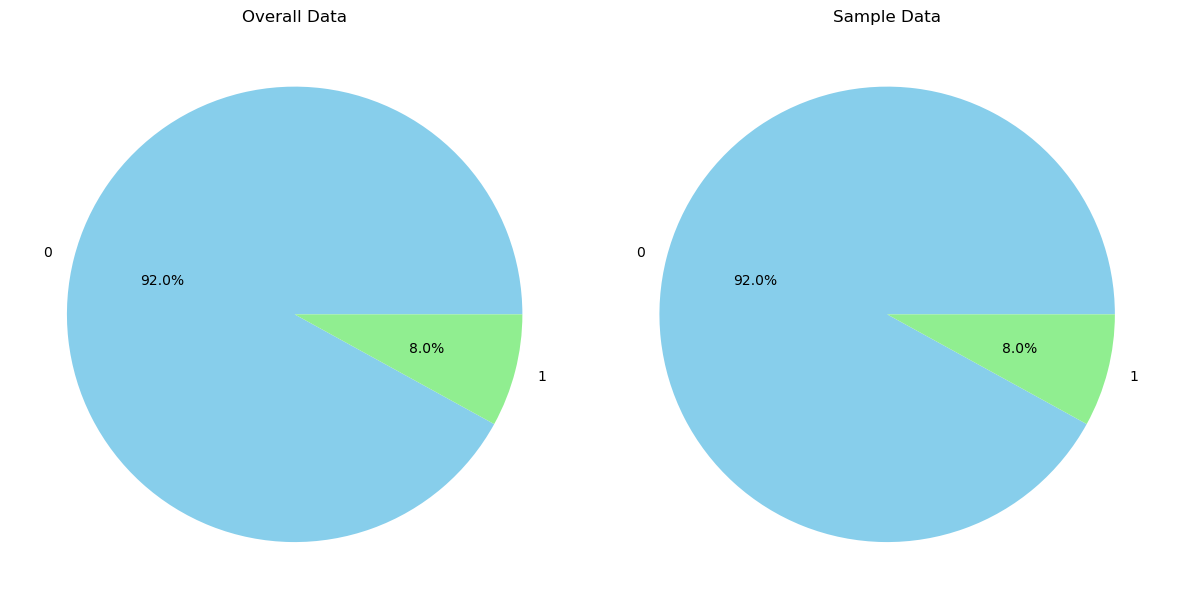

In [48]:
# Calculate counts for each category in the overall Data
overall_counts = appliances_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculate counts for each category in the sample Data
sample_counts = appliances_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Pie Chart
plt.figure(figsize=(12, 6))

# Plot pie chart for the overall Data
plt.subplot(1, 2, 1)
plt.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Overall Data')

# Plot pie chart for the sample Data
plt.subplot(1, 2, 2)
plt.pie(sample_counts, labels=sample_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Sample Data')

plt.tight_layout()
plt.show()



#### I can conclude sample data is same as overall population

In [50]:
appliances_df_working_dedup_filter_sample.dtypes

overall                        int64
vote                          object
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
style                         object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
image_available                 bool
helpfulness_binary             int64
dtype: object

## Feature engineering


#### 1) Review title (summary) metadata:
1a) # words in title

1b) # length of original title

1c) Similarity of title and review text (using cosine similarity or related method)(This is optional as it is computational expensive)

1d) Title sentiment

1e) Unique word count

1f) Emoji & non-ASCII character count

1g) Term frequency/TFIDF of the cleaned title with prefix of title if summary is not similar to text (might be tricky to do)


#### 2) Review text (reviewText) metadata:
2a) # words in review

2b) # length of original review

2c) Review sentiment

2d) Unique word count

2e) URL availability inside reviewtext

2f) Stop word count  

2g) Emoji & non-ASCII character count

#### 4) Active reviewer - does the reviewer ID have multiple reviews? 1 if yes, 0 otherwise
Active reviewer can be removed 


#### 5) Age of review: (end of 2018 - review posted date) = review age in days


#### 6) Review text cleaning:
6a) convert reviewtext to lowercase, remove double spaces, punctuations, numbers

6c) Remove URLs, stopwords (standard and custom), non-ASCII characters, emojis and other non-printable characters

6d) Remove sparse words

6e) lemmatization

6f) n-grams: Check for top unigrams and bigrams - study distributions


In [51]:
# Function definitions

# Function for number of words in input text
def num_words(text):
    return len(word_tokenize(text))

# Function to get length of input text
def text_length(text):
    return len(text)

# Cosine similarity between 2 input texts: this may be computationally expensive
# Cosine similarity between title and review text is calculated using TF-IDF
def cosine_similarity(title, review):
    vectorizer = TfidfVectorizer()
    tf_idf_matrix = vectorizer.fit_transform([title, review])
    return (tf_idf_matrix * tf_idf_matrix.T).toarray()[0][1]

# Sentiment polarity
# <0 indicates negative sentiment
# 0 indicates netural
# >0 indicates positive sentiment
def text_sentiment(title):
    blob = TextBlob(title)
    return blob.sentiment.polarity

# Function to get count of unique words in the input text
def unique_word_count(text):
    return len(set(word_tokenize(text)))

# Function to get count of emojis and non-ASCII characters in input text
def emoji_and_non_ascii_count(text):
    count = 0
    for char in text:
        if (char in emoji.UNICODE_EMOJI or not char.isascii()):
            count += 1
    return count

# If UNICODE_EMOJI isn't getting installed, use this version of the function
# This uses a regex pattern to capture non-alphanumeric characters
def emoji_and_non_ascii_count_v2(text):
    emoji_pattern = r"[^a-zA-Z0-9\s+\.\!]"
    return len(re.findall(emoji_pattern, text))

# Function to count the number of URLs inside the input text
def url_count(text):
    url_pattern = r"http[s]?://\S+"  # Regular expression for URLs
    return len(re.findall(url_pattern, text))

# Function to count the number of English stopwords in the input text
def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return sum(word in stop_words for word in words)


In [52]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
# Creating features 1a - 1f

# 1a: Number of words in the title
appliances_df_working_dedup_filter_sample['num_words_review_title'] = appliances_df_working_dedup_filter_sample['summary'].apply(num_words)
# 1b. length of original title
appliances_df_working_dedup_filter_sample['title_length'] = appliances_df_working_dedup_filter_sample['summary'].apply(text_length)

# 1d: Sentiment polarity
appliances_df_working_dedup_filter_sample['title_sentiment'] = appliances_df_working_dedup_filter_sample['summary'].apply(text_sentiment)

# 1e: Unique word count
appliances_df_working_dedup_filter_sample['unique_word_count_title'] = appliances_df_working_dedup_filter_sample['summary'].apply(unique_word_count)

# 1f: Emoji & non-ASCII character count
#appliances_df_working_dedup['emoji_non_ascii_count_title'] = appliances_df_working_dedup['summary'].apply(emoji_and_non_ascii_count)

# 1f: Emoji & non-ASCII character count v2
appliances_df_working_dedup_filter_sample['emoji_non_ascii_count_title'] = appliances_df_working_dedup_filter_sample['summary'].apply(emoji_and_non_ascii_count_v2)


# Check
appliances_df_working_dedup_filter_sample.shape

(49995, 25)

In [54]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
# Creating features 2a - 2g

# 2a: Number of words in the review
appliances_df_working_dedup_filter_sample['num_words_review_text'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(num_words)

# 2b. length of original review
appliances_df_working_dedup_filter_sample['review_length'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(text_length)

# 2c: Sentiment polarity of review
appliances_df_working_dedup_filter_sample['review_sentiment'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(text_sentiment)

# 2d: Unique word count
appliances_df_working_dedup_filter_sample['unique_word_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(unique_word_count)

# 2e: URL count inside reviewtext
appliances_df_working_dedup_filter_sample['url_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(url_count)

# 2f: Stop word count
appliances_df_working_dedup_filter_sample['stop_word_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(stopword_count)

# 2g: Emoji & non-ASCII character count
appliances_df_working_dedup_filter_sample['emoji_non_ascii_count_title'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(emoji_and_non_ascii_count_v2)

# Check
print(appliances_df_working_dedup_filter_sample.shape)

(49995, 31)


In [57]:
appliances_df_working_dedup_filter_sample

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,title_length,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title,num_words_review_text,review_length,review_sentiment,unique_word_count_review,url_count_review,stop_word_count_review
60325,5,NaN,True,"01 4, 2010",AG1KGR2RGETJW,B00149JVOC,NaN,D. Trent Loman,Item was as described and arrived on time. I ...,Saved $$ when purchasing 3-pack,...,31,0.00000,5,1,17,81,0.000000,16,0,6
14941,4,NaN,True,"01 5, 2010",A1QV78VYQVHV23,B0007CXPCG,"{'Color:': ' Callaway', 'Style Name:': ' Elect...",Sabrina A in VA,"I have a slightly older set, made by a differe...",A little brighter than expected,...,31,-0.14375,5,6,32,148,0.108333,25,0,11
8103,5,NaN,False,"01 10, 2010",A2HO2ZE978BKN8,B0002GD194,NaN,SBush68,This item came exactly as described and works ...,Exactly as described,...,20,0.25000,3,1,20,109,0.595833,19,0,4
92042,1,23,False,"01 28, 2010",A1WUEAIKB94UVT,B001IMTWZS,NaN,Alberto Caputo,I have this stove for a few years and it cost ...,the worst,...,9,-1.00000,2,10,83,337,-0.217727,54,0,30
46916,5,NaN,False,"01 23, 2010",A16SSSU1OMPH7Q,B000L3IRRO,NaN,TeX,I've had this about 3 years. Bought it used w...,Great Value in a front load washer,...,34,0.80000,7,6,148,669,0.097236,94,0,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600080,5,2.0,True,"08 4, 2018",A3LLKJIK1ISE6B,B01FT48K3U,NaN,AzleTexan,These OnePurify filters fit our Samsung perfec...,Fit our Samsung perfectly,...,25,0.70000,4,3,69,332,0.475000,56,0,31
457027,5,3.0,True,"08 15, 2018",A1PLD5X6BNQ9YM,B01EKO8OQ8,{'Color:': ' White'},Cindy,"I hate to say it, all HE washers need to die. ...",I hate to say it,...,16,-0.80000,5,18,208,935,0.217424,123,0,80
594031,1,2.0,True,"08 15, 2018",A102VDY4J5AYI2,B01AYTUFV0,{'Size:': ' 175-can'},Glenn M. Nowacki,Arrived damaged. Wouldnt cool past 45 degrees...,Do not buy,...,10,0.00000,3,2,30,148,0.250000,29,0,5
599963,1,2.0,True,"08 25, 2018",A2EEWMDGHYTAR1,B01FRKS0AY,NaN,Kurt Gundersen,I purchased a SABA Air 2 Door Commercial Refer...,Leaky Evaporator Coil,...,21,0.00000,3,4,130,659,-0.005000,91,0,42


In [50]:
# Feature 4: active reviewer
'''
# Finding the count the rows (reviews) across the dataset
review_counts = appliances_df_working_dedup_filter_sample.groupby('reviewerID')['reviewerID'].size().to_frame(name='review_count')

# Joining the review counts back to the original dataframe on reviewerID
appliances_df_working_dedup_filter_sample = appliances_df_working_dedup_filter_sample.merge(review_counts, on='reviewerID', how='left')

# Check
print(appliances_df_working_dedup_filter_sample)
'''

       overall vote  verified   reviewTime      reviewerID        asin  \
0            1   23     False  01 28, 2010  A1WUEAIKB94UVT  B001IMTWZS   
1            3  NaN      True   01 9, 2010  A2OTFJUMQF12ZC  B000AO1G72   
2            4   45     False  01 10, 2010  A14J87NHJAGPYR  B002Z7OEDK   
3            5  NaN      True   01 7, 2010  A2EBNX5TO6KPQD  B0007CXPCG   
4            5  NaN      True   01 7, 2010  A1ASXFIJDOVW1C  B001BOTNCU   
...        ...  ...       ...          ...             ...         ...   
49990        2    2      True   08 7, 2018   ANXUAZK2MP2SL  B01H1R0K68   
49991        5  2.0      True   08 4, 2018  A3LLKJIK1ISE6B  B01FT48K3U   
49992        1  2.0      True  08 15, 2018  A102VDY4J5AYI2  B01AYTUFV0   
49993        5  4.0      True   08 9, 2018  A1JKDU6WLQGCCH  B01G8E17WQ   
49994        1  2.0      True   09 2, 2018  A29XQ7TO555X3V  B01ALBMIEI   

                                                   style      reviewerName  \
0                                

In [56]:
# 5) Age of review: (end of 2018 - review posted date) = review age in days

# Calculating the end date of 2018 as the reference date since the dataset is as of 2018
end_of_2018 = datetime(2018, 12, 31)

# Converting datetime64[ns] to pandas datetime
if pd.api.types.is_datetime64_dtype(appliances_df_working_dedup_filter_sample['reviewTime_cleaned']):
    appliances_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(appliances_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Calculating the age in days
appliances_df_working_dedup_filter_sample['review_age_days'] = (end_of_2018 - appliances_df_working_dedup_filter_sample['reviewTime_cleaned']).dt.days


In [57]:
# Check
appliances_df_working_dedup_filter_sample.shape

(49995, 32)

In [58]:
# 6: Text cleaning

# Defining a master function that will do the following for a provided input text:
# 6a) Lowercase and remove double spaces
# 6b) Expand contractions
# 6c) Remove unwanted characters, numbers, punctuations

import re
import string
import contractions
from nltk.corpus import stopwords

# 6a) Lowercase and remove double spaces
def remove_urls_html_tags(text):
    pattern = r"https?://\S+|www\.\S+|<.*?>"
    return re.sub(pattern, "", text, flags=re.MULTILINE)

# 6b) Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# 6c) Remove unwanted characters, numbers, punctuations
def remove_non_ascii_and_emojis(text):
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', re.sub(r'[^\x00-\x7F]+', r'', text))

# Remove punctuations & Numbers
def remove_punctuations_and_digits(text):
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translation_table)

# Resolving acronyms and abbreviations - add more as required
def expand_acronyms_and_abbreviations(text):
    acronyms_abbrs = {
        "tbh": "to be honest",
        "2mw": "tomorrow",
        "lol": "laugh out loud",
        "fyi": "for your information",
        "acct": "account",
        "adih": "another day in hell",
        "afaic": "as far as i am concerned",
        "afaict": "as far as i can tell",
        "afaik": "as far as i know",
        "afair": "as far as i remember",
        "afk": "away from keyboard",
        "gr8": "great",
        "omg": "oh my god",
        "omw": "on my way"
    }

    for acronym, full_form in acronyms_abbrs.items():
        text = text.replace(acronym, full_form)

    return text

# Custom stopwords (add to list here as required)
# Remove stopwords
def remove_stopwords(text):
    custom_stopwords = ["amazon"]
    stop_words = stopwords.words("english") + custom_stopwords
    return " ".join([word for word in text.split() if word not in stop_words])

def clean_text_master_function_v2(text):
    text = text.lower()
    text = text.replace("  ", " ")  # Remove double spaces
    text = remove_urls_html_tags(text)
    text = remove_non_ascii_and_emojis(text)
    text = remove_punctuations_and_digits(text)
    text = expand_contractions(text)
    text = expand_acronyms_and_abbreviations(text)
    text = remove_stopwords(text)
    return text


In [59]:
# Applying the cleaning function to the reviewText column
appliances_df_working_dedup_filter_sample['review_text_clean'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(clean_text_master_function_v2)

In [60]:
appliances_df_working_dedup_filter_sample['review_text_clean'].shape

(49995,)

In [61]:
# Creating functions for stemming and lemmatization
# Using WordNet Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in text]

In [62]:
# Apply stemming and lemmatization as new columns
appliances_df_working_dedup_filter_sample['review_text_clean_lemmatized'] = appliances_df_working_dedup_filter_sample['review_text_clean'].apply(lemmatize_text)

In [63]:
appliances_df_working_dedup_filter_sample.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'image_available',
       'helpfulness_binary', 'num_words_review_title', 'title_length',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'num_words_review_text', 'review_length',
       'review_sentiment', 'unique_word_count_review', 'url_count_review',
       'stop_word_count_review', 'review_age_days', 'review_text_clean',
       'review_text_clean_lemmatized'],
      dtype='object')

In [65]:
appliances_df_working_dedup_filter_sample['review_text_clean'].head

<bound method NDFrame.head of 75030     filters work well fairly easy replace humidifi...
591878    days purchasing appliance stopped turned displ...
45065     used one cartridges kept shutting humidifier c...
14941     slightly older set made different subcontracto...
2384        power cord one length quality good easy install
                                ...                        
601049    best outdoor refrigerator hot climates much re...
457029    first load love currently washing husbands wor...
423811    machine worked pretty well spinner stopped wor...
423805    awesome product right size single person livin...
423723                                             far good
Name: review_text_clean, Length: 49995, dtype: object>

In [66]:
# Converting to csv
appliances_df_working_dedup_filter_sample.to_csv('Appliances_cleaned.csv', index=False)

In [67]:
# Reading in Appliances sample data
appliances_df = pd.read_csv('Appliances_cleaned.csv')

In [69]:
'''
This function compares the distribution of top n-grams (unigrams or bigrams) for two groups in a DataFrame.

Args:
  df: The DataFrame containing the text data and a column for the comparison group ('helpfulness_binary').
  helpfulness_values: A list of the two values to compare (e.g., [1, 0] for helpfulness).
  n: The n-gram value (1 for unigrams, 2 for bigrams).
  top_n: Number of top n-grams to visualize (default: 20)
'''

# The function output is the visualization of the top n-grams for a given dataframe
def compare_top_ngram_distribution(df, helpfulness_values, n, top_n=20):
  # Creating TF-IDF vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(n, n), lowercase=True, sublinear_tf=True)

  # Handling lists of tokens in 'review_text_clean'
    def preprocess_text(text):
        if isinstance(text, list):
            return ' '.join(text)
        else:
            return text

    # Preprocessing text and fit vectorizer
    data = df['review_text_clean'].apply(preprocess_text)
    vectorizer.fit_transform(data)

    # Getting TF-IDF scores for each helpfulness value
    tfidf_matrix = vectorizer.transform(data)
    tfidf_by_helpfulness = {val: tfidf_matrix[df['helpfulness_binary'] == val].toarray() for val in helpfulness_values}

    # Getting vocabulary
    vocabulary = vectorizer.get_feature_names_out()

    # Calculating average TF-IDF scores for top n-grams per helpfulness value
    top_ngram_scores = {}
    for val in helpfulness_values:
        tfidf_data = tfidf_by_helpfulness[val]
        top_ngram_indices = tfidf_data.sum(axis=0).argsort()[-top_n:]  # Get indices of top n words by sum of TF-IDF
        top_ngram_scores[val] = [ (vocabulary[i], tfidf_data[:, i].mean()) for i in top_ngram_indices ]
    # Plotting
    plt.figure(figsize=(10, 6))

  # Preparing data for visualization (separate lists for ngrams and TF-IDF by helpfulness)
    ngrams = []
    avg_tfidf_by_helpfulness = {}
    for val, scores in top_ngram_scores.items():
        ngrams.extend([ngram for ngram, _ in scores])  # ngram for labels
        avg_tfidf_by_helpfulness[f"Helpfulness={val}"] = [tfidf for _, tfidf in scores]

  # Sorting together by TF-IDF (descending)
    sorted_data = sorted(zip(ngrams, *avg_tfidf_by_helpfulness.values()), key=lambda x: x[1], reverse=True)
    sorted_ngrams, *sorted_tfidf_by_helpfulness = zip(*sorted_data)

  # Creating colors for each helpfulness value (adjust as needed)
    colors = ['blue', 'orange']

  # Creating clustered column chart
    x = range(len(sorted_ngrams))  # x-axis positions
    bar_width = 0.35  # Adjust bar width for better visualization
    plt.bar(x[:top_n], sorted_tfidf_by_helpfulness[0][:top_n], bar_width, label=f"Helpfulness={helpfulness_values[0]}", color=colors[0])
    plt.bar([p + bar_width for p in x[:top_n]], sorted_tfidf_by_helpfulness[1][:top_n],
            bar_width, label=f"Helpfulness={helpfulness_values[1]}", color=colors[1])

  # Setting x-axis labels with rotation for readability
    plt.xticks([p + bar_width/2 for p in x[:top_n]], sorted_ngrams[:top_n], rotation=60)
    plt.xlabel("Top N-Grams")
    plt.ylabel("Average TF-IDF Score")
    plt.title(f"Distribution of Top {n}-Gram TF-IDF Scores by Helpfulness Rating")
    plt.legend()
    plt.tight_layout()
    plt.show()


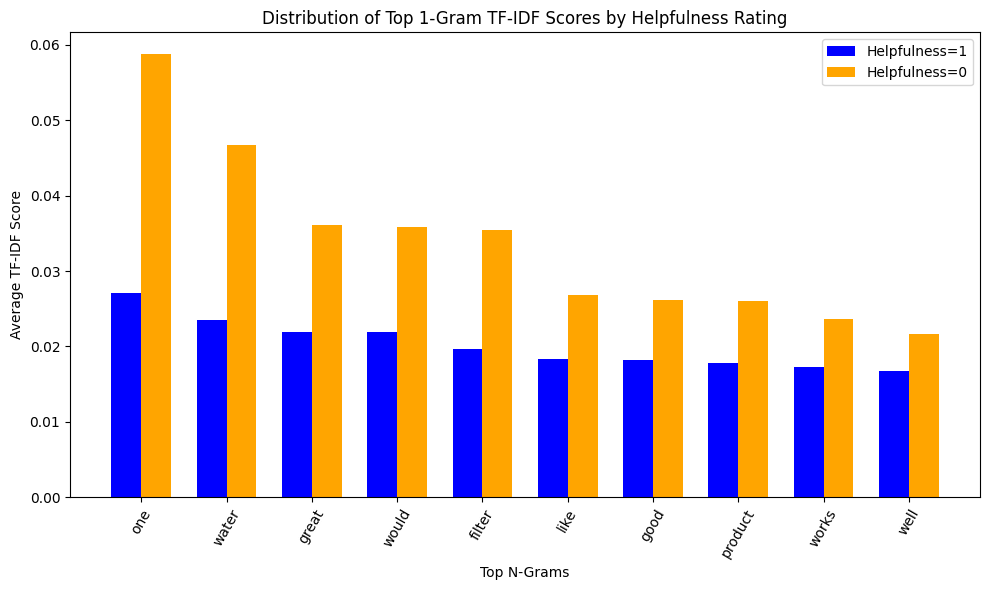

In [70]:
helpfulness_values = [1, 0]  # List of helpfulness ratings to compare

# Compare top 20 unigram distribution
compare_top_ngram_distribution(appliances_df_working_dedup_filter_sample.copy(), helpfulness_values, 1, top_n=10)

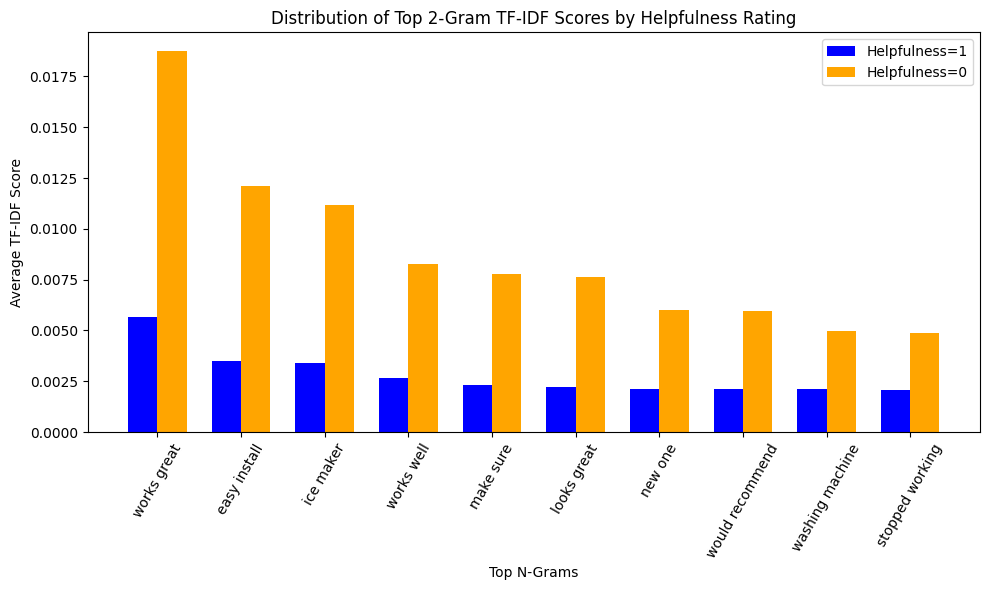

In [71]:
# Compare top 20 bigram distribution
compare_top_ngram_distribution(appliances_df_working_dedup_filter_sample.copy(), helpfulness_values, 2, top_n=10)


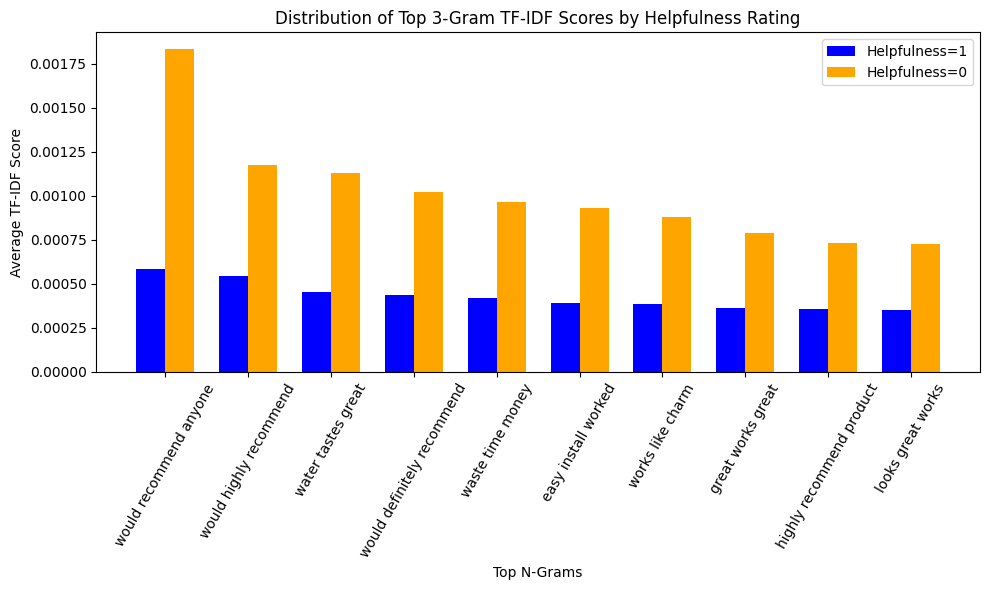

In [72]:
# Compare top 20 trigram distribution
compare_top_ngram_distribution(appliances_df_working_dedup_filter_sample.copy(), helpfulness_values, 3, top_n=10)


# Modeling

#### Steps:
1) Choose ONLY metadata features for correlation (there will be 5k tfidf features, not feasible to check correlation)
2) Define high correlation threshold, can be >=0.85 for high positive correlation and <=-0.85 for high negative correlation
3) Check correlation matrix and exclude highly correlated unimportant features
4) Visualize correlation matrix again with final list and ensure that no 2 features are outside correlation thresholds
5) Create TFIDF matrix and convert to dataframe
6) Modeling dataframes - X will contain all features i.e. TFIDF features and finalized metadata features, y will contain the target variable i.e. helpfulness_binary
7) Split of modeling datasets into train (80%) and test (20%)
8) Training the supervised ML models; 2 sets of models will be trained - base models and tuned models
9) Base models will run with default parameters while tuned models will be run after identifying optimal parameters obtained from hyperparameter tuning
10) Compare the base and tuned models' performance
11) Compare the models
12) Feature importance of the models
13) Model explainability (extension of feature importance) and identifying drivers of helpfulness for insights
    - For tree-based models (Random Forest / XGBoost) - feature importance of review terms

### Modeling dataset creation

In [78]:
import itertools

# Specifying the metadata features for checking correlation
other_meta_features = [
                  'image_available',
                  'title_length',
                  'num_words_review_title', #'title_review_similarity', # commented if not calculated
                  'title_sentiment',
                  'unique_word_count_title',
                  'emoji_non_ascii_count_title',
                  'review_length',
                  'review_sentiment',
                  'num_words_review_text',
                  'url_count_review',
                  'unique_word_count_review',
                  'stop_word_count_review',
                  'review_age_days'
                 ]

# Getting only metadata feature columns for correlation checks
metadata_features_corr_check = appliances_df_working_dedup_filter_sample[other_meta_features]

In [79]:
# Metadata features for correlation check
metadata_features_corr_check.columns

Index(['image_available', 'title_length', 'num_words_review_title',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'review_length', 'review_sentiment',
       'num_words_review_text', 'url_count_review', 'unique_word_count_review',
       'stop_word_count_review', 'review_age_days'],
      dtype='object')

In [80]:
metadata_features_corr_check.shape

(49995, 13)

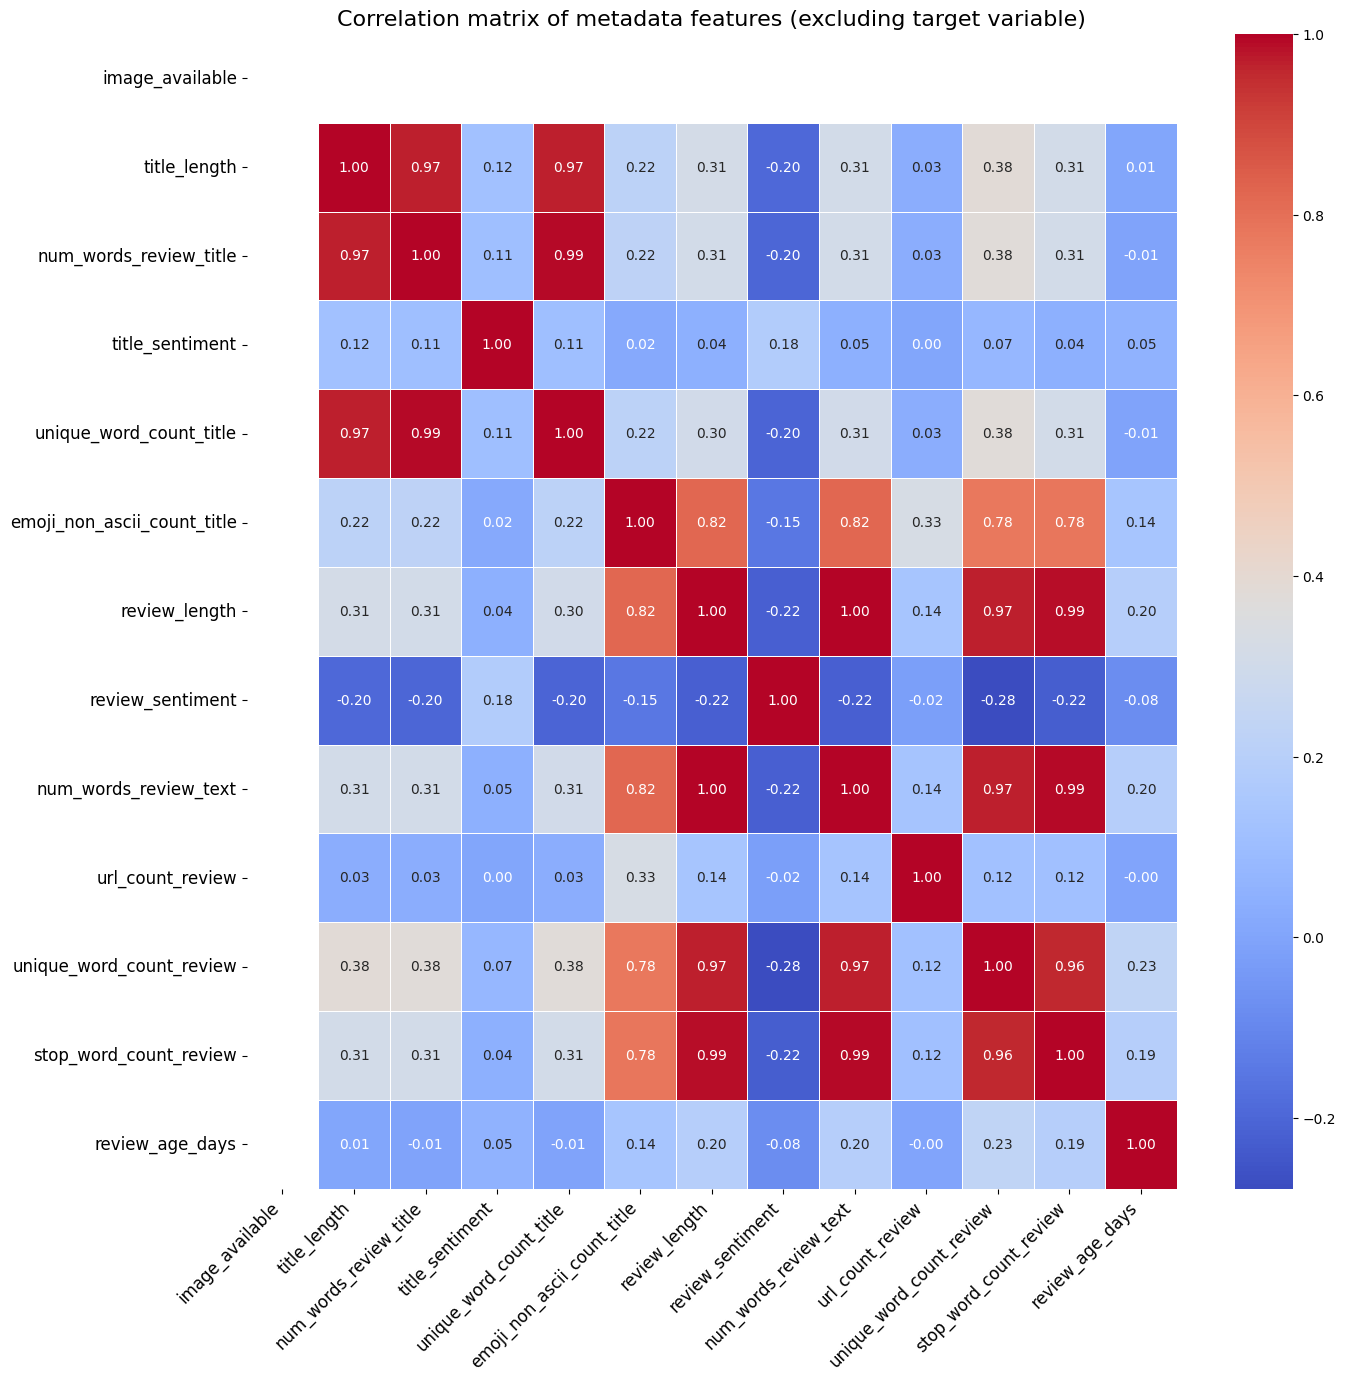

In [81]:
# Initial correlation analysis
import seaborn as sns

# Getting only metadata feature columns to check correlation
correlation_matrix_corr_check = metadata_features_corr_check.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_corr_check, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increase title fontsize
plt.show()

In [82]:
# Need to study the above matrix and remove correlated metadata features
correlation_matrix_corr_check

,image_available,title_length,num_words_review_title,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title,review_length,review_sentiment,num_words_review_text,url_count_review,unique_word_count_review,stop_word_count_review,review_age_days
image_available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title_length,NaN,1.000000,0.966987,0.118872,0.968957,0.219895,0.312665,-0.195401,0.309751,0.032992,0.381332,0.310279,0.005847
num_words_review_title,NaN,0.966987,1.000000,0.111057,0.993022,0.221813,0.307656,-0.201515,0.308414,0.032402,0.378077,0.310085,-0.005722
title_sentiment,NaN,0.118872,0.111057,1.000000,0.111013,0.018088,0.044849,0.178550,0.045250,0.001797,0.073609,0.042973,0.054463
unique_word_count_title,NaN,0.968957,0.993022,0.111013,1.000000,0.218710,0.304637,-0.203799,0.305047,0.032127,0.376401,0.307016,-0.006709
emoji_non_ascii_count_title,NaN,0.219895,0.221813,0.018088,0.218710,1.000000,0.822850,-0.153164,0.824381,0.328477,0.777396,0.783022,0.138469
review_length,NaN,0.312665,0.307656,0.044849,0.304637,0.822850,1.000000,-0.218602,0.998187,0.140794,0.965589,0.987410,0.195429
review_sentiment,NaN,-0.195401,-0.201515,0.178550,-0.203799,-0.153164,-0.218602,1.000000,-0.219598,-0.019874,-0.278202,-0.224767,-0.080354
num_words_review_text,NaN,0.309751,0.308414,0.045250,0.305047,0.824381,0.998187,-0.219598,1.000000,0.135281,0.966057,0.990305,0.195116
url_count_review,NaN,0.032992,0.032402,0.001797,0.032127,0.328477,0.140794,-0.019874,0.135281,1.000000,0.119547,0.116029,-0.000673


#### After analysing correlation matrix, there are a lot of correlated feature. Deciding the cut-off as more than 0.85. Any feature that is more than 0.85 is highly postively correlated. Any feature that is less than -0.85 is highly negatively correlated.

In [83]:
# Removing highly correlated features
# Uncorrelated metadata features are identified through manual judgement i.e. heuristic approach

# Droping the columns from the dataframe
corr_columns_to_drop = ["review_length", "stop_word_count_review",
                        "unique_word_count_title","num_words_review_title","num_words_review_text",
                        # Removing image_available since it's binary/boolen and isn't relevant for correlation checks
                        "image_available"]
metadata_features_corr_check.drop(columns=corr_columns_to_drop, inplace=True)

In [84]:
metadata_features_corr_check.shape

(49995, 7)

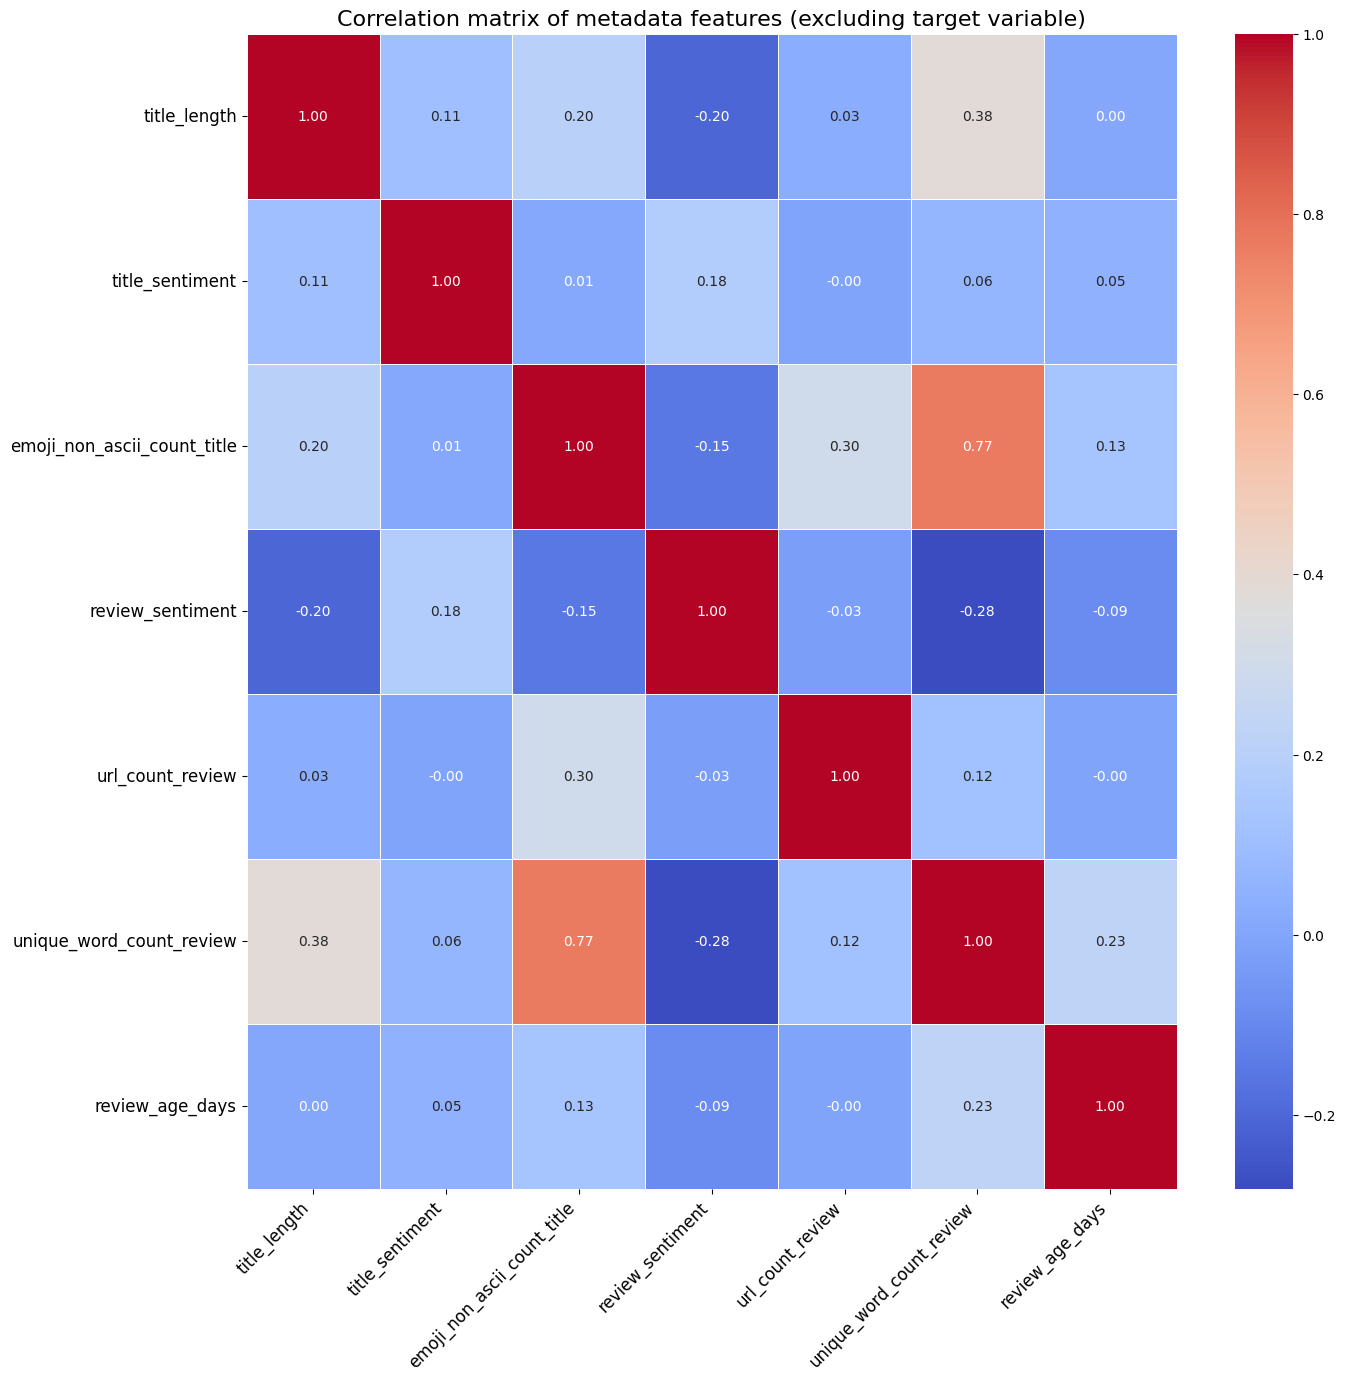

In [74]:
import seaborn as sns
# Getting only uncorrelated metadata feature columns to check correlation
metadata_features_final = metadata_features_corr_check.copy()
correlation_matrix_final = metadata_features_final.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_final, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keeping y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increasing title fontsize
plt.show()

#### After removing highly corelated features above matrix is the final correlation matrix.

In [85]:
# Creating final modeling dataset

# Defining the columns to be taken in modeling dataset
target_column = 'helpfulness_binary'  # Helpfulness is binary (1 or 0)

# Defining final metadata features after ensuring that no independent metadata features are highly correlated
# List of columns comes from metadata_features_final.columns
final_meta_features = ['title_length', 'title_sentiment', 'emoji_non_ascii_count_title', 'review_sentiment',
                       'url_count_review', 'unique_word_count_review','review_age_days',
                       # including image_available since it was dropped in correlation matrix
                       'image_available']

# Getting only metadata feature columns
modeling_df_meta_final = appliances_df_working_dedup_filter_sample[final_meta_features]

In [82]:
appliances_df_working_dedup_filter_sample.shape

(49995, 34)

In [83]:
modeling_df_meta_final.shape

(49995, 8)

In [86]:
# Creating TFIDF matrix of cleaned review text and storing in a df
# Custom tokenizer function
def custom_tokenizer(text):
    # Splitting text into words using a simple whitespace tokenizer
    words = text.split()
    return words

# Tokenizing text using custom tokenizer
tokenized_text = appliances_df_working_dedup_filter_sample['review_text_clean'].apply(custom_tokenizer).apply(' '.join)

# Creating TF-IDF vectorizer instance with custom tokenizer and top 1000 features
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_text)

# Converting TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [87]:
tfidf_df.shape

(49995, 1000)

In [87]:
# Combining TF-IDF features with other features

# Restting index on both TFIDF dataframe and metadata feature dataframe
tfidf_df.reset_index(drop=True, inplace=True)
modeling_df_meta_final.reset_index(drop=True, inplace=True)

# Splitting into X and y for modeling
# X will have the TFIDF df and the final metadata features
X = pd.concat([tfidf_df, modeling_df_meta_final], axis=1)

# y will have the target variable
y = appliances_df_working_dedup_filter_sample[target_column]

In [88]:
# convert to csv
X.to_csv('Appliances_X_values.csv', index=False)

In [87]:
# Checking size - this should be the same as the stratified sample output df size
X.shape

(49995, 1008)

In [89]:
# Splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39996, 1008)
X_test shape: (9999, 1008)
y_train shape: (39996,)
y_test shape: (9999,)


In [90]:
# convert to csv
X_train.to_csv('Appliances_XTrain_values.csv', index=False)

In [90]:
# convert to csv
y_train.to_csv('Appliances_YTrain_values.csv', index=False)

In [91]:
y_train

539022    0
430488    1
252818    0
494785    0
336434    0
         ..
499917    0
270209    0
400735    0
303113    0
320613    0
Name: helpfulness_binary, Length: 39996, dtype: int64

## Modeling - Supervised ML models to predict helpfulness

In [92]:
# Libraries required
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, f1_score, auc
import matplotlib.pyplot as plt

### Modeling - Random Forest

In [93]:
# Random Forest Classifier - base model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest base model accuracy:", rf_accuracy)
print("Random Forest base model classification report:")
print(classification_report(y_test, rf_predictions))

Random Forest base model accuracy: 0.9201920192019202
Random Forest base model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9214
           1       0.07      0.00      0.00       785

    accuracy                           0.92      9999
   macro avg       0.49      0.50      0.48      9999
weighted avg       0.85      0.92      0.88      9999



In [94]:
# Random Forest Classifier - Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=123), param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_
print("Random Forest Best Parameters:", rf_best_params)

rf_tuned_predictions = rf_grid_search.predict(X_test)

rf_tuned_predictions = rf_grid_search.predict(X_test)
rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_predictions)
print("Random Forest tuned model accuracy:", rf_tuned_accuracy)
print("Random Forest tuned model classification report:")
print(classification_report(y_test, rf_tuned_predictions))

Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 50}
Random Forest tuned model accuracy: 0.9214921492149215
Random Forest tuned model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9214
           1       0.50      0.01      0.02       785

    accuracy                           0.92      9999
   macro avg       0.71      0.50      0.49      9999
weighted avg       0.89      0.92      0.89      9999



### Modeling - Logistic Regression

In [94]:
# Logistic Regression - base model
lr_classifier = LogisticRegression(max_iter=1000, random_state=123)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression base model accuracy:", lr_accuracy)
print("Logistic Regression base model classification report:")
print(classification_report(y_test, lr_predictions))

Logistic Regression base model accuracy: 0.9203920392039204
Logistic Regression base model classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9214
           1       0.45      0.07      0.12       785

    accuracy                           0.92      9999
   macro avg       0.69      0.53      0.54      9999
weighted avg       0.89      0.92      0.89      9999



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [111]:
# Logistic Regression - Hyperparameter Tuning
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 20],
    'penalty': ['l1', 'l2']
}

lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=123),
                              param_grid=lr_param_grid, cv=3, scoring='accuracy')
lr_grid_search.fit(X_train, y_train)
lr_best_params = lr_grid_search.best_params_
lr_best_model = lr_grid_search.best_estimator_
print("Logistic Regression Best Parameters:", lr_best_params)

lr_tuned_predictions = lr_grid_search.predict(X_test)

lr_tuned_predictions = lr_grid_search.predict(X_test)
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_predictions)
print("Logistic Regression tuned model accuracy:", lr_tuned_accuracy)
print("Logistic Regression tuned model classification report:")
print(classification_report(y_test, lr_tuned_predictions))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/

Logistic Regression Best Parameters: {'C': 1, 'penalty': 'l2'}
Logistic Regression tuned model accuracy: 0.9195919591959196
Logistic Regression tuned model classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9214
           1       0.43      0.08      0.14       785

    accuracy                           0.92      9999
   macro avg       0.68      0.54      0.55      9999
weighted avg       0.89      0.92      0.89      9999



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Modeling - SVM

In [96]:
# Support Vector Machine (SVM) - base model--HPC
svm_classifier = SVC(kernel='rbf', random_state=123)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM base model accuracy:", svm_accuracy)
print("SVM base model classification report:")
print(classification_report(y_test, svm_predictions))

SVM base model accuracy: 0.9214921492149215
SVM base model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9214
           1       0.00      0.00      0.00       785

    accuracy                           0.92      9999
   macro avg       0.46      0.50      0.48      9999
weighted avg       0.85      0.92      0.88      9999



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Support Vector Machine (SVM) - Hyperparameter Tuning
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_grid_search = GridSearchCV(SVC(random_state=123), param_grid=svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)
svm_best_params = svm_grid_search.best_params_
svm_best_model = svm_grid_search.best_estimator_

print("SVM Best Parameters:", svm_best_params)

svm_tuned_predictions = svm_grid_search.predict(X_test)

svm_tuned_predictions = svm_grid_search.predict(X_test)
svm_tuned_accuracy = accuracy_score(y_test, svm_tuned_predictions)
print("SVM tuned model accuracy:", svm_tuned_accuracy)
print("SVM tuned model classification report:")
print(classification_report(y_test, svm_tuned_predictions))

### Modeling - XGBoost

In [95]:
# XGBoost - base model
xgb_classifier = xgb.XGBClassifier(random_state=123)
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost base model accuracy:", xgb_accuracy)
print("XGBoost base model classification report:")
print(classification_report(y_test, xgb_predictions))

XGBoost base model accuracy: 0.9184918491849184
XGBoost base model classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9214
           1       0.41      0.08      0.14       785

    accuracy                           0.92      9999
   macro avg       0.67      0.54      0.55      9999
weighted avg       0.89      0.92      0.89      9999



In [98]:
# XGBoost - Hyperparameter Tuning
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=123), param_grid=xgb_param_grid, cv=3, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

print("XGBoost Best Parameters:", xgb_best_params)

xgb_tuned_predictions = xgb_grid_search.predict(X_test)

xgb_tuned_predictions = xgb_grid_search.predict(X_test)
xgb_tuned_accuracy = accuracy_score(y_test, xgb_tuned_predictions)
print("XGBoost tuned model accuracy:", xgb_tuned_accuracy)
print("XGBoost tuned model classification report:")
print(classification_report(y_test, xgb_tuned_predictions))

XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost tuned model accuracy: 0.9217921792179218
XGBoost tuned model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9214
           1       0.62      0.01      0.02       785

    accuracy                           0.92      9999
   macro avg       0.77      0.50      0.49      9999
weighted avg       0.90      0.92      0.89      9999



### Model comparison and feature importance

Random Forest Confusion Matrix:
[[9200   14]
 [ 784    1]]
Random Forest F1-Score: 0.0025
Random Forest AUC: 0.4998772291956715
Random Forest Accuracy: 0.9201920192019202
Random Forest Precision: 0.06666666666666667
Random Forest Recall: 0.0012738853503184713

Logistic Regression Confusion Matrix:
[[9150   64]
 [ 732   53]]
Logistic Regression F1-Score: 0.11751662971175167
Logistic Regression AUC: 0.5302849858772098
Logistic Regression Accuracy: 0.9203920392039204
Logistic Regression Precision: 0.452991452991453
Logistic Regression Recall: 0.06751592356687898

SVM Confusion Matrix:
[[9214    0]
 [ 785    0]]
SVM F1-Score: 0.0
SVM AUC: 0.5
SVM Accuracy: 0.9214921492149215
SVM Precision: 1.0
SVM Recall: 0.0

XGBoost Confusion Matrix:
[[9119   95]
 [ 720   65]]
XGBoost F1-Score: 0.13756613756613756
XGBoost AUC: 0.5362460752745407
XGBoost Accuracy: 0.9184918491849184
XGBoost Precision: 0.40625
XGBoost Recall: 0.08280254777070063



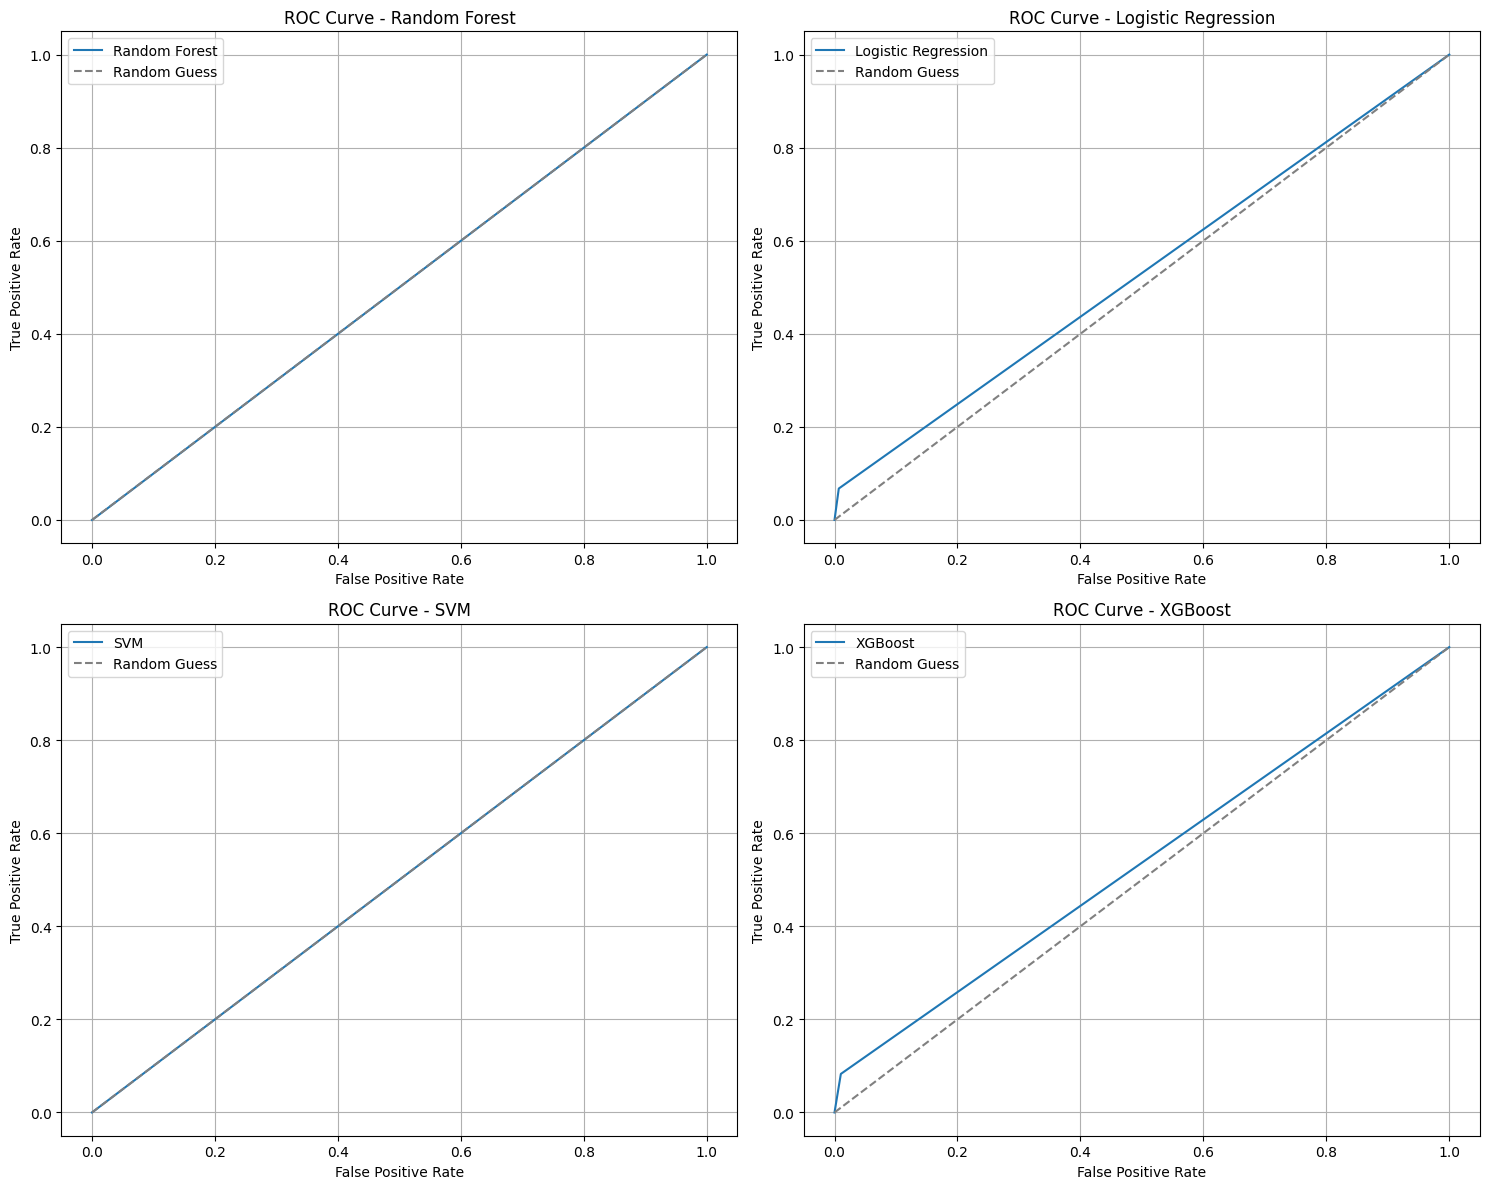

In [97]:
from sklearn.metrics import precision_score, recall_score
# Function to plot ROC curve
def plot_roc_curve(ax, fpr, tpr, model_name):
    ax.plot(fpr, tpr, label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend()
    ax.grid(True)

# Function to evaluate and compare models
def evaluate_models(models, X_test, y_test):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

    for model_name, model in models.items():
        ax = axes.flatten()[list(models.keys()).index(model_name)]

        # Predictions
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"{model_name} Confusion Matrix:")
        print(cm)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plot_roc_curve(ax, fpr, tpr, model_name)

        # F1-Score
        f1 = f1_score(y_test, y_pred)
        print(f"{model_name} F1-Score: {f1}")

        # Area under ROC curve
        roc_auc = auc(fpr, tpr)
        print(f"{model_name} AUC: {roc_auc}")

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {accuracy}")

        # Precision
        precision = precision_score(y_test, y_pred, zero_division=1)
        print(f"{model_name} Precision: {precision}")

        # Recall
        recall = recall_score(y_test, y_pred)
        print(f"{model_name} Recall: {recall}")

        print()

    plt.tight_layout()
    plt.show()

# Defining the models to compare
'''tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}
'''

base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}


# Evaluation and comparison of models
#evaluate_models(tuned_models, X_test, y_test)
evaluate_models(base_models, X_test, y_test)

In [100]:
# Function to plot feature importance (top 20 as default)
def plot_top_n_feature_importance(importance, names, model_name, top_n=20):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    top_features = feature_importance.head(top_n)
    plt.figure(figsize=(20, 12))
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.show()

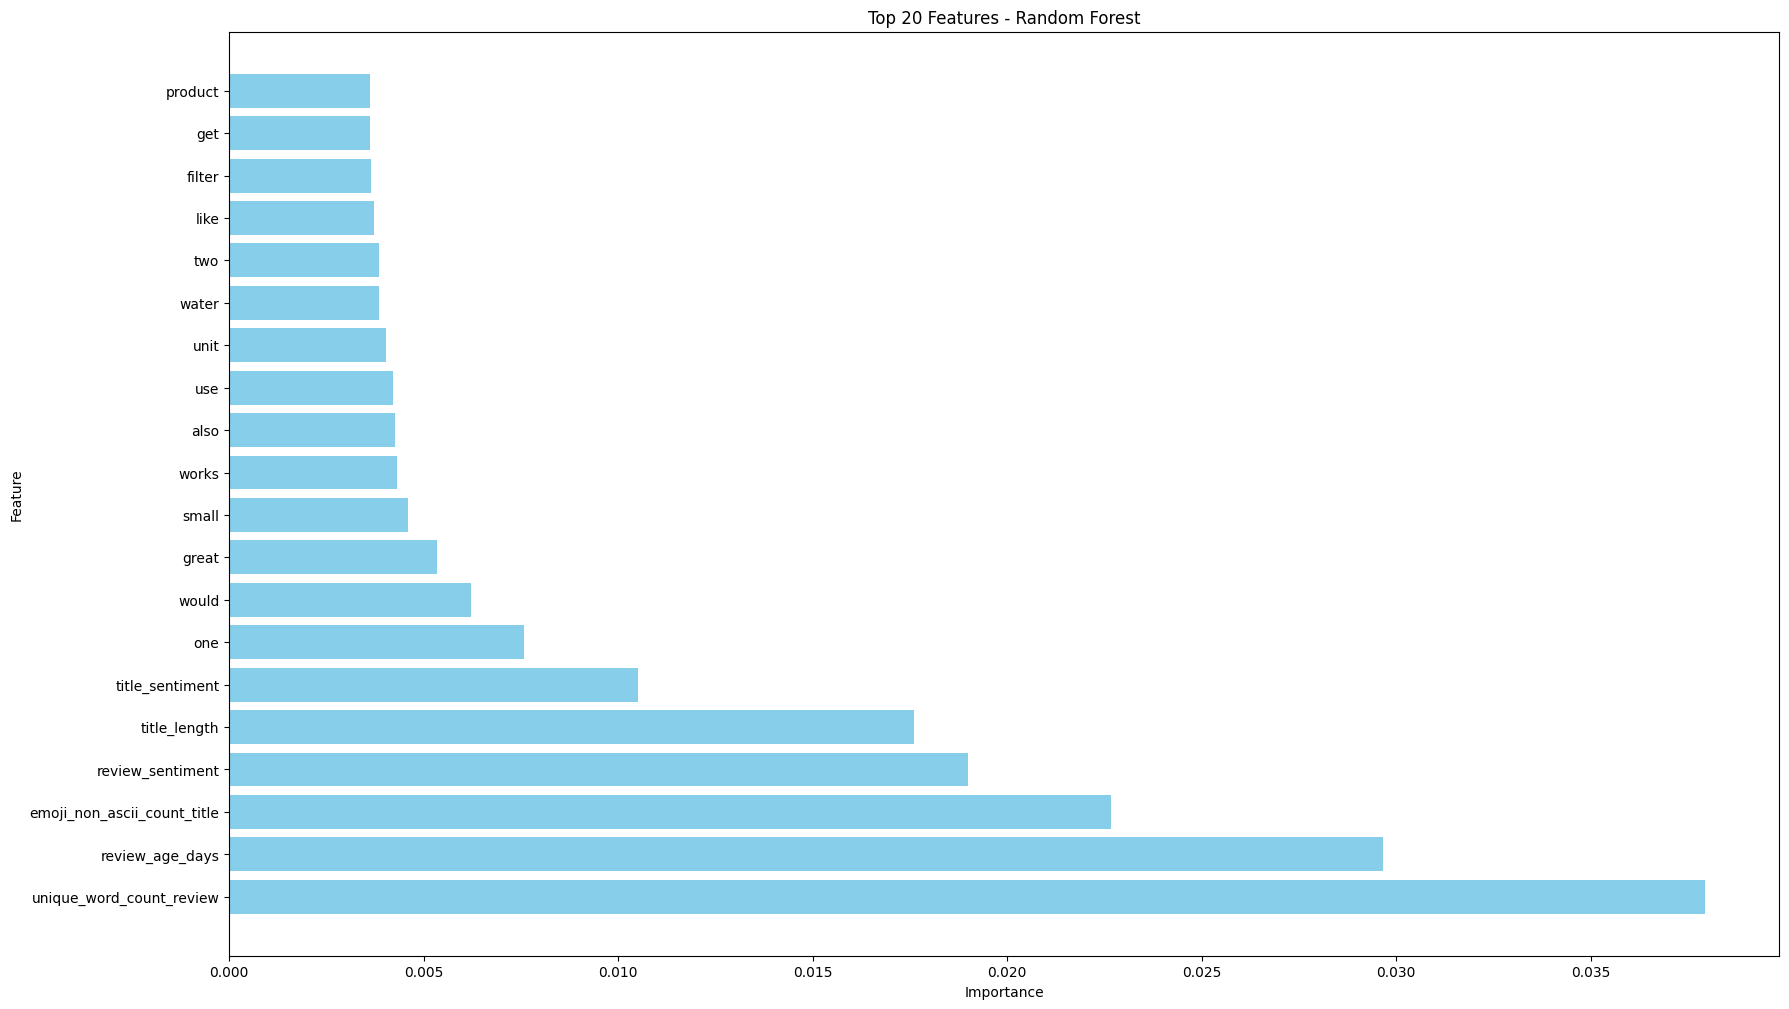

In [101]:
# Random Forest Feature Importance
#rf_feature_importance = rf_best_model.feature_importances_
rf_feature_importance = rf_classifier.feature_importances_
plot_top_n_feature_importance(rf_feature_importance, X_train.columns, 'Random Forest', 20)

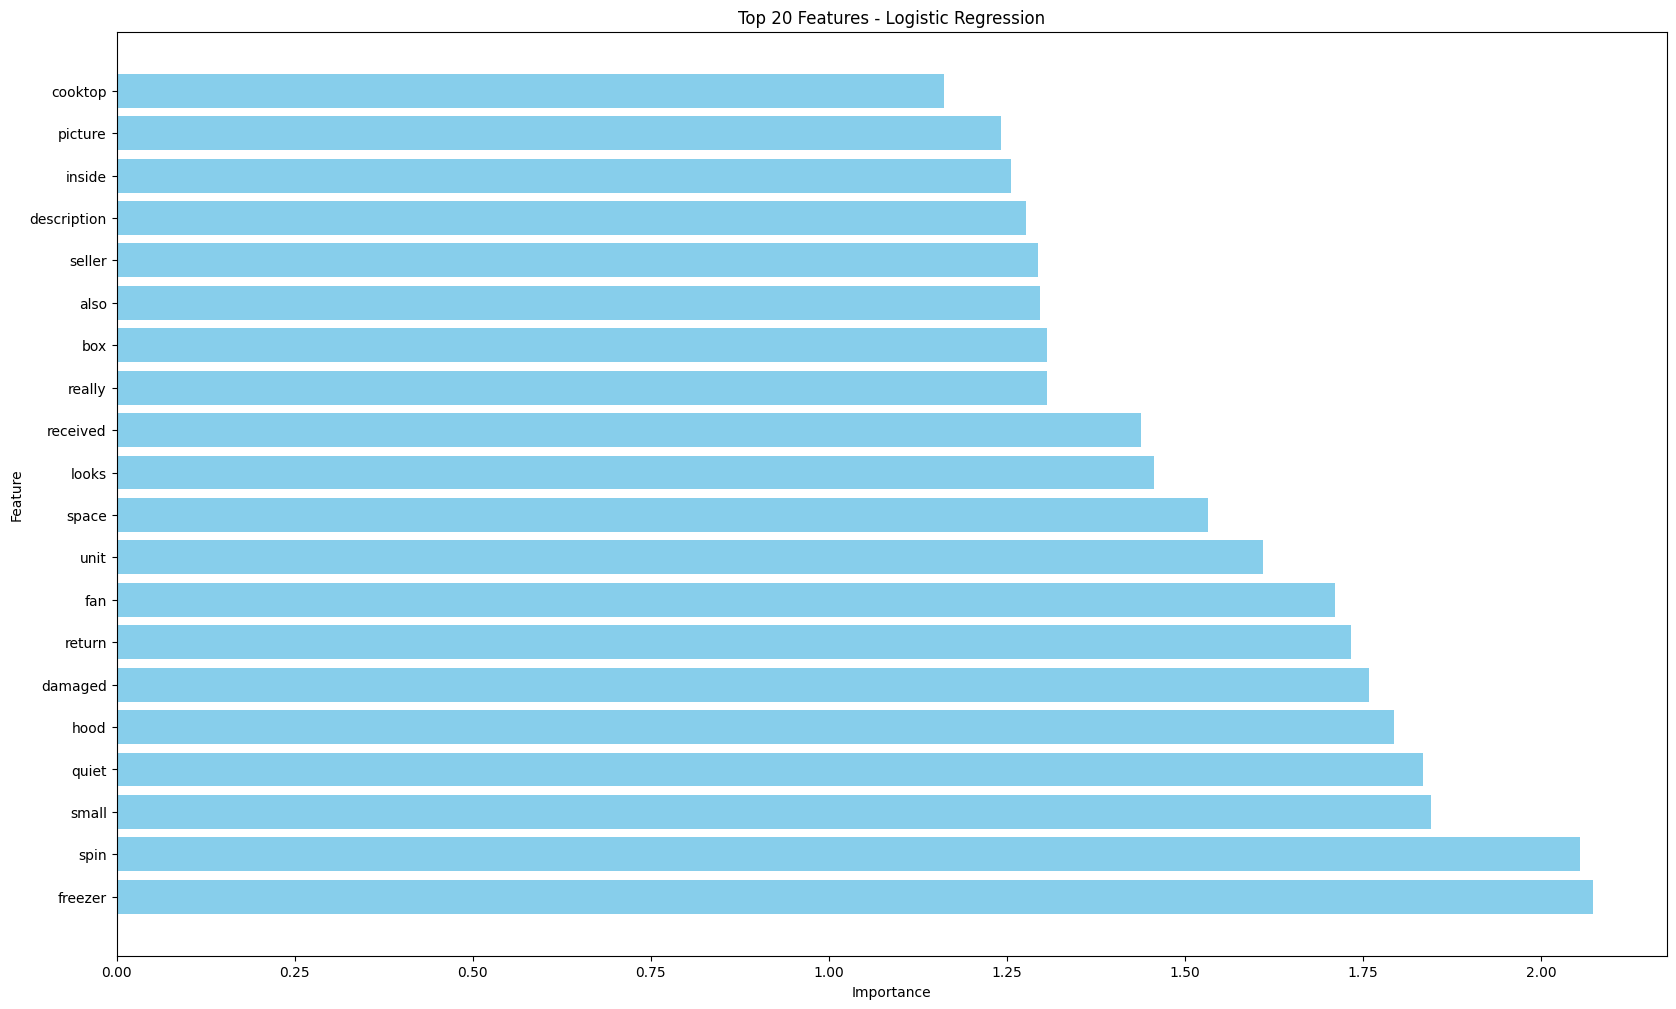

In [102]:
# Logistic Regression Coefficients (for positive and negative impact)
#lr_feature_importance = lr_best_model.coef_[0]
lr_feature_importance = lr_classifier.coef_[0]
plot_top_n_feature_importance(lr_feature_importance, X_train.columns, 'Logistic Regression')

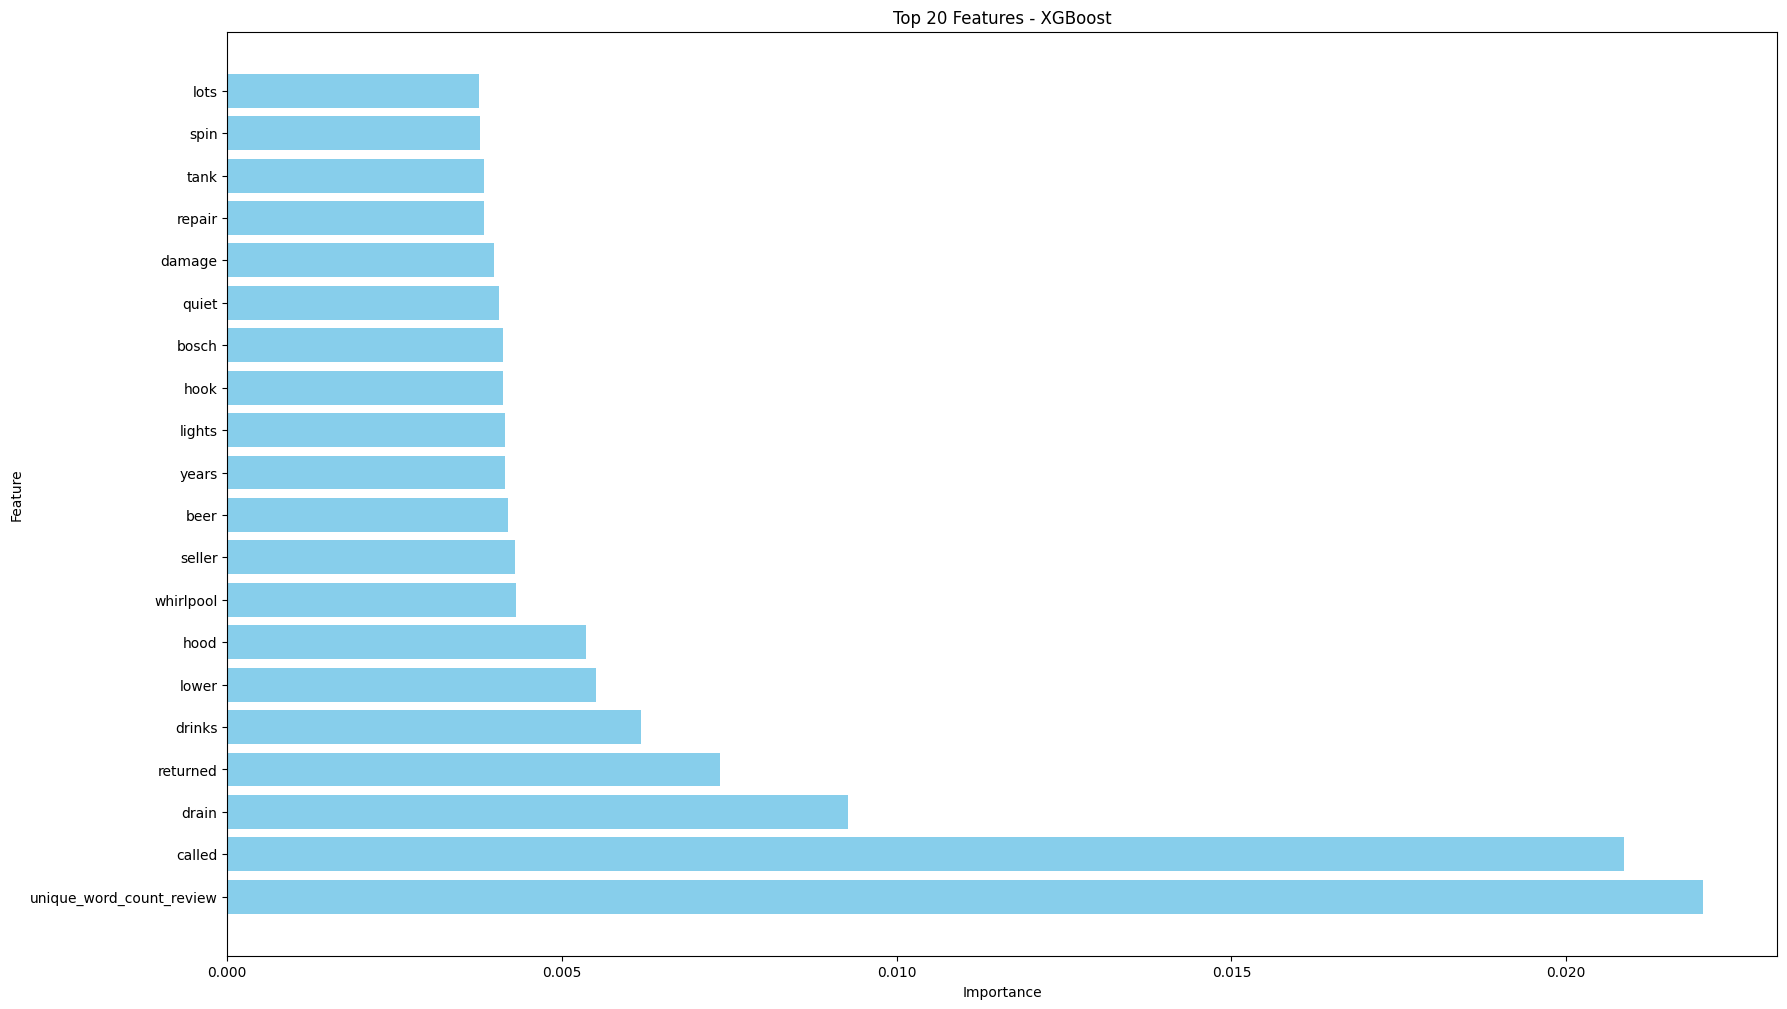

In [103]:
# XGBoost Feature Importance
#xgb_feature_importance = xgb_best_model.feature_importances_
xgb_feature_importance = xgb_classifier.feature_importances_
plot_top_n_feature_importance(xgb_feature_importance, X_train.columns, 'XGBoost')

In [104]:
X_train.columns

Index(['able', 'absolutely', 'accurate', 'across', 'actual', 'actually',
       'adapter', 'add', 'added', 'additional',
       ...
       'yet', 'youtube', 'title_length', 'title_sentiment',
       'emoji_non_ascii_count_title', 'review_sentiment', 'url_count_review',
       'unique_word_count_review', 'review_age_days', 'image_available'],
      dtype='object', length=1008)

### Model explainability and drivers of helpfulness- Work in Progress (Good to have)

In [105]:
def plot_imp_feature_distribution_hist(df, feature_name, target_column):
    sns.set(style="whitegrid", rc={"grid.linewidth": 0})  # rc parameter to be tweaked to get gridlines
    plt.figure(figsize=(8, 6))

    # Mapping numerical values to labels
    label_map = {0: 'Not Helpful', 1: 'Helpful'}
    df['target_labels'] = df[target_column].map(label_map)

    sns.histplot(data=df, x=feature_name, hue='target_labels', multiple="stack", legend=True)
    plt.title(f'Distribution of {feature_name} across Helpfulness Levels')
    plt.xlabel(feature_name)
    plt.ylabel('Count')

    # Modifying the legend labels directly
    plt.legend(title='Helpfulness', labels=['Not Helpful', 'Helpful'])

    plt.show()


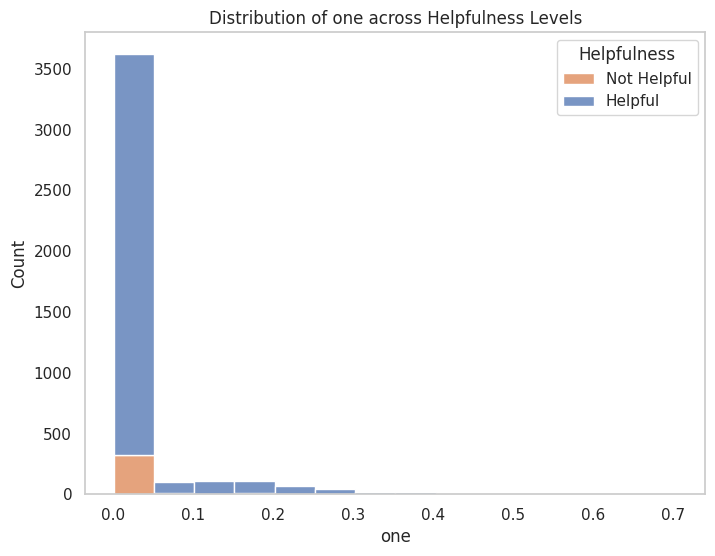

In [106]:
# Specifying the (important) feature that needs to be explored across helpfulness values
feature_to_explore = 'one'

# Plotting the feature distribution across helpfulness
plot_imp_feature_distribution_hist(pd.concat([X, y], axis=1), feature_to_explore, 'helpfulness_binary')

In [107]:
# Function to plot distribution of a single feature across helpfulness - stacked bar chart
def plot_imp_feature_distribution_stabar(df, feature_name, target_column):
    sns.set(style="whitegrid", rc={"grid.linewidth": 0})  # rc parameter to be tweaked to get gridlines
    plt.figure(figsize=(12, 8))  # Increased figure size

    # Maping numerical values to labels
    label_map = {0: 'Not Helpful', 1: 'Helpful'}
    df['target_labels'] = df[target_column].map(label_map)

    # Creating a pivot table to calculate the count of each feature value for values of helpfulness
    pivot_table = df.groupby([feature_name, 'target_labels']).size().unstack()

    # Plotting the stacked bar chart
    pivot_table.plot(kind='bar', stacked=True)

    plt.title(f'Distribution of {feature_name} across Helpfulness Levels')
    plt.xlabel(feature_name)
    plt.ylabel('Count')

    # Modifying the legend labels directly
    plt.legend(title='Helpfulness', labels=['Not Helpful', 'Helpful'])

    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


<Figure size 1200x800 with 0 Axes>

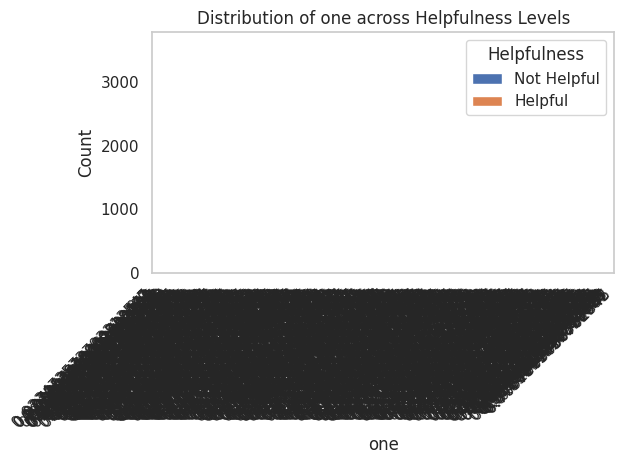

In [108]:
# Specifying the (important) feature that needs to be explored across helpfulness values
feature_to_explore = 'one'

# Plotting the feature distribution across helpfulness
plot_imp_feature_distribution_stabar(pd.concat([X, y], axis=1), feature_to_explore, 'helpfulness_binary')

In [109]:
y

60325     0
14941     0
8103      0
92042     0
46916     0
         ..
600080    1
457027    1
594031    1
599963    1
600132    1
Name: helpfulness_binary, Length: 49995, dtype: int64

#### For tree-based models (Random Forest / XGBoost) - feature importance of review terms

In [110]:
# Specifying the tree based classifier instance to get the feature importance values
#feature_importances = rf_classifier.feature_importances_
feature_importances = xgb_classifier.feature_importances_

# Obtaining feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting the dictionary by importance (descending order)
sorted_feature_importance_desc = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the top N important terms along with their relative importance
top_n = 20
for term, importance in sorted_feature_importance_desc[:top_n]:
    print(f"Review term: {term}, Importance: {importance}")

Review term: called, Importance: 0.020867928862571716
Review term: drain, Importance: 0.009270665235817432
Review term: returned, Importance: 0.0073571340180933475
Review term: drinks, Importance: 0.00617495970800519
Review term: lower, Importance: 0.005503831431269646
Review term: hood, Importance: 0.0053660208359360695
Review term: whirlpool, Importance: 0.004307609982788563
Review term: seller, Importance: 0.004304555244743824
Review term: beer, Importance: 0.004190359264612198
Review term: years, Importance: 0.004153191111981869
Review term: lights, Importance: 0.004144788254052401
Review term: hook, Importance: 0.004119648598134518
Review term: bosch, Importance: 0.004114577546715736
Review term: quiet, Importance: 0.004062671214342117
Review term: damage, Importance: 0.0039892978966236115
Review term: repair, Importance: 0.0038357048761099577
Review term: tank, Importance: 0.0038355099968612194
Review term: spin, Importance: 0.003778934245929122
Review term: lots, Importance: 0.0